<a href="https://colab.research.google.com/github/EnesGokceDS/Pet_Insurace_Claim_Prediction/blob/master/Pet_Claim_Prediction_Enes_Gokce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import subprocess as sp
import sys,os,shutil,pickle,time
from os.path import join
# mount Google Drive
from os.path import expanduser
gd_path=join(expanduser("~"),'gd')
if not os.path.isdir(gd_path):
    try:
        # load Google Drive
        from google.colab import drive,files
        drive.mount('/drive')
        sp.call('ln -s /drive/My\ Drive '+gd_path, shell=True)
    except:
        print('unable to find Google Drive Folder')
os.chdir(gd_path+'/MachineLearning/Trupanion_data')
os.listdir('.')

['claimdata.csv', 'petdata.csv', 'small_tree.dot', 'small_tree.png']

In [0]:
import pandas as pd
import numpy as np

In [0]:
df_claim = pd.read_csv('claimdata.csv')

In [0]:
df_claim.sample(5)

,ClaimId,PetId,ClaimDate,ClaimAmount
19530,20282,8838,2016-03-04,114.67
8612,8853,6560,2013-12-28,74.64
22963,23796,8584,2017-10-19,178.14
15167,15860,8909,2015-04-09,84.44
2531,2646,4092,2019-05-13,58.28


In [0]:
df_claim.shape

(37049, 4)

In [0]:
df_pet = pd.read_csv('petdata.csv')
df_pet.sample(10)

,PetId,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll
8281,8281,2013-04-16,2016-05-05,Dog,Mixed Breed,7 years old
7645,7645,2016-03-11,2016-06-20,Cat,Mixed Breed,2 years old
6816,6816,2014-01-21,NaN,Cat,Mixed Breed,8 weeks to 12 months old
1253,1253,2015-01-19,2017-07-20,Dog,Mixed Breed,8 weeks to 12 months old
8897,8897,2015-11-25,NaN,Cat,Mixed Breed,8 years old
7685,7685,2019-02-08,NaN,Dog,Golden Retriever,6 years old
6717,6717,2016-04-22,NaN,Cat,Mixed Breed,2 years old
1976,1976,2011-11-04,2019-04-26,Dog,Chihuahua,2 years old
3760,3760,2016-08-31,2017-08-30,Cat,Mixed Breed,8 weeks to 12 months old
1128,1128,2019-09-16,NaN,Dog,Golden Retriever,2 years old


In [0]:
df_pet.shape

(10000, 6)

In [0]:
n_PetId_claim = df_claim.PetId.unique().size
n_PetId_pet= df_pet.PetId.unique().size
print ("Number of unique PetID in claim data:  %i" % n_PetId_claim)
print ("Number of unique PetID in Pet data:  %i" % n_PetId_pet)

Number of unique PetID in claim data:  4027
Number of unique PetID in Pet data:  10000


Let's make a double check whether there is any zero value in claim data

In [0]:
df_claim.loc[df_claim.ClaimAmount == 0].count()

ClaimId        0
PetId          0
ClaimDate      0
ClaimAmount    0
dtype: int64

I need to create two columns: current age and claim age

*   Still enrolled 0-1. En son modelı gelıstırdıkten sonra test datayı sadece enrolled data ustunde çalıştırabilirim.

Claim amount monthly

AS: Cancel date'den sonra herhangi bir claim var mi?


Now, let's merge the pet data to claim data

In [0]:
df = df_claim.merge(df_pet, on='PetId', how='right')


In [0]:
df.shape

(43022, 9)

In [0]:
df.sample(10)

,ClaimId,PetId,ClaimDate,ClaimAmount,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll
25696,22383.0,4219,2017-08-23,1745.85,2017-01-13,NaN,Dog,Chihuahua,5 years old
11923,36437.0,2141,2018-06-14,90.98,2013-06-15,2019-08-19,Dog,Mixed Breed,5 years old
41336,NaN,7191,NaN,NaN,2018-02-21,NaN,Cat,Mixed Breed,8 weeks to 12 months old
25544,6016.0,6027,2014-08-03,38.01,2012-07-25,NaN,Dog,Mixed Breed,8 weeks to 12 months old
39456,NaN,3988,NaN,NaN,2018-08-16,NaN,Dog,Mixed Breed,7 years old
23847,17416.0,6132,2013-09-14,153.95,2011-07-25,2019-08-24,Dog,Mixed Breed,2 years old
16791,8756.0,7399,2013-12-02,60.83,2010-02-17,2014-01-09,Cat,Mixed Breed,13 years old
20310,37635.0,2145,2010-10-31,122.39,2010-10-19,NaN,Dog,Mixed Breed,8 weeks to 12 months old
10836,2304.0,5083,2014-06-27,24.13,2014-06-27,NaN,Dog,Mixed Breed,8 weeks to 12 months old
2838,39162.0,9193,2017-05-12,19.93,2013-08-19,NaN,Dog,Mixed Breed,8 weeks to 12 months old


In [0]:
df.reindex(df.PetId).head(10)

,ClaimId,PetId,ClaimDate,ClaimAmount,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll
PetId,,,,,,,,,
9273,24073.0,8874,2013-07-12,295.54,2010-09-18,NaN,Dog,Mixed Breed,8 weeks to 12 months old
9273,24073.0,8874,2013-07-12,295.54,2010-09-18,NaN,Dog,Mixed Breed,8 weeks to 12 months old
9273,24073.0,8874,2013-07-12,295.54,2010-09-18,NaN,Dog,Mixed Breed,8 weeks to 12 months old
9273,24073.0,8874,2013-07-12,295.54,2010-09-18,NaN,Dog,Mixed Breed,8 weeks to 12 months old
9273,24073.0,8874,2013-07-12,295.54,2010-09-18,NaN,Dog,Mixed Breed,8 weeks to 12 months old
9273,24073.0,8874,2013-07-12,295.54,2010-09-18,NaN,Dog,Mixed Breed,8 weeks to 12 months old
9273,24073.0,8874,2013-07-12,295.54,2010-09-18,NaN,Dog,Mixed Breed,8 weeks to 12 months old
9273,24073.0,8874,2013-07-12,295.54,2010-09-18,NaN,Dog,Mixed Breed,8 weeks to 12 months old
9273,24073.0,8874,2013-07-12,295.54,2010-09-18,NaN,Dog,Mixed Breed,8 weeks to 12 months old


Let's see most frequent PetID that made claims

In [0]:
df_claim.PetId.value_counts().nlargest(10)

3957    306
9633    242
4991    196
7050    171
2922    170
9193    170
3522    147
2261    140
1517    130
270     123
Name: PetId, dtype: int64

In [0]:
df.isna().sum()

ClaimId         5973
PetId              0
ClaimDate       5973
ClaimAmount     5973
EnrollDate         0
CancelDate     26600
Species            0
Breed              0
AgeAtEnroll        0
dtype: int64

**Data Wrangling**

With some data wrangling, let's investigate and explore our data more deeply

In [0]:
list(df.AgeAtEnroll.unique())

['8 weeks to 12 months old',
 '6 years old',
 '3 years old',
 '1 year old',
 '5 years old',
 '9 years old',
 '13 years old',
 '7 years old',
 '4 years old',
 '8 years old',
 '10 years old',
 '2 years old',
 '11 years old',
 '12 years old',
 '0-7 weeks old']

We need to tidy this column for later usage. We can replace all age values with a number. 

I will replace
*  '8 weeks to 12 months old' with 0.75 
*   '0-7 weeks old' with 0.1 
All age column will represent pets' age as year.



In [0]:
df= df.replace(['8 weeks to 12 months old', '0-7 weeks old'], ['0.75', '0.1'])

In [0]:
list(df.AgeAtEnroll.unique())

['0.75',
 '6 years old',
 '3 years old',
 '1 year old',
 '5 years old',
 '9 years old',
 '13 years old',
 '7 years old',
 '4 years old',
 '8 years old',
 '10 years old',
 '2 years old',
 '11 years old',
 '12 years old',
 '0.1']

##### Now, let's take only numbers from 'AgeAtEnroll' column



In [0]:
df['AgeAtEnroll']= df['AgeAtEnroll'].str.split(" ",expand= True)[0]
list(df.AgeAtEnroll.unique())

['0.75',
 '6',
 '3',
 '1',
 '5',
 '9',
 '13',
 '7',
 '4',
 '8',
 '10',
 '2',
 '11',
 '12',
 '0.1']

Now, let's change the data type to numeric

In [0]:
df["AgeAtEnroll"] = pd.to_numeric(df["AgeAtEnroll"],errors='coerce')
df.AgeAtEnroll.dtypes

dtype('float64')

Looking at age at claim time can also be helpful because it tells us age of getting sick. In order to get AgeAtClaim. I will:

*   Get the difference between enrollment date and claim date
*   Add this difference to the AgeAtEnrollment 

In [0]:
df.dtypes

ClaimId        float64
PetId            int64
ClaimDate       object
ClaimAmount    float64
EnrollDate      object
CancelDate      object
Species         object
Breed           object
AgeAtEnroll    float64
dtype: object

Here, as we can see, the dates aren't in datetime format. We need to convert it.

In [0]:
df['ClaimDate'] = pd.to_datetime(df['ClaimDate'])
df['EnrollDate'] = pd.to_datetime(df['EnrollDate'])
df['CancelDate'] = pd.to_datetime(df['CancelDate']) # Let's convert this, too, for later use

In [0]:
df.dtypes

ClaimId               float64
PetId                   int64
ClaimDate      datetime64[ns]
ClaimAmount           float64
EnrollDate     datetime64[ns]
CancelDate     datetime64[ns]
Species                object
Breed                  object
AgeAtEnroll           float64
dtype: object

Now, let's convert days to years, and then add it to the age, then call it '*AgeAtClaim*'

In [0]:
 difference= df['ClaimDate'].sub(df['EnrollDate'], axis=0)
 difference.head()


0   420 days
1   231 days
2   239 days
3   329 days
4    28 days
dtype: timedelta64[ns]

In [0]:
difference = difference.astype(str)

In [0]:
difference= difference.str.split(" ",expand= True)[0]

Now, we only have numbers in 'difference' variable. We can convert it to float and divide by 365 in order to find difference yearly

In [0]:
difference = pd.to_numeric(difference,errors='coerce')

In [0]:
difference.head()

0    420.0
1    231.0
2    239.0
3    329.0
4     28.0
Name: 0, dtype: float64

In [0]:
difference_yearly= difference/365
difference_yearly.sample(5)

34189    1.597260
11021    1.791781
7254     3.460274
29288    4.104110
35420    2.438356
Name: 0, dtype: float64

In [0]:
AgeAtClaim= df.AgeAtEnroll + difference_yearly

In [0]:
df['AgeAtClaim']= AgeAtClaim.round(decimals=2)
df.sample(10)

,ClaimId,PetId,ClaimDate,ClaimAmount,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,AgeAtClaim
31439,10936.0,6008,2019-03-09,80.83,2014-06-09,2019-05-14,Dog,Mixed Breed,0.75,5.50
23024,18986.0,1371,2015-12-18,25.87,2015-07-31,2016-09-28,Dog,Golden Retriever,0.75,1.13
28297,27657.0,8301,2014-12-01,155.25,2014-10-13,2017-09-21,Dog,Mixed Breed,2.00,2.13
20570,26563.0,5057,2018-10-10,45.42,2011-08-21,NaT,Dog,Mixed Breed,0.75,7.89
40507,NaN,5760,NaT,NaN,2012-07-18,2014-10-02,Cat,Mixed Breed,4.00,NaN
32819,35525.0,8299,2017-11-15,978.30,2015-03-27,NaT,Cat,Mixed Breed,8.00,10.64
21111,27247.0,7495,2018-09-08,43.70,2018-06-09,NaT,Cat,Ragdoll,0.75,1.00
37509,NaN,776,NaT,NaN,2012-01-24,2012-01-26,Cat,Mixed Breed,0.75,NaN
27753,5924.0,3807,2014-08-26,148.92,2010-09-27,2016-06-14,Cat,Mixed Breed,2.00,5.92
16506,16514.0,8834,2015-06-08,116.52,2010-08-19,NaT,Dog,Mixed Breed,0.75,5.56




---
####Let's check whether if there is any claim after cancelling the insurance



In [0]:
 difference= df['CancelDate'].sub(df['ClaimDate'], axis=0) 

In [0]:
difference.sort_values().head()

32386   0 days
17548   0 days
36650   0 days
31708   0 days
20139   0 days
dtype: timedelta64[ns]

As we can see, there is no positive days, which means we don't have any claim after cancelling the insurance plan. This information can be useful when we are doing the analysis

###Now, let's take a look at ClaimAmount for each pet in total

In [0]:
df.groupby('PetId').ClaimAmount.agg(['sum','count']).sample(10)

,sum,count
PetId,,
1776,5553.46,102
9236,0.00,0
6236,13925.46,13
6666,20415.53,10
9494,0.00,0
8819,501.66,4
3937,12475.55,5
843,124.64,1
515,496.19,5


In [0]:
total_amount= df.groupby('PetId').ClaimAmount.transform('sum')

In [0]:
df['total_amount']=total_amount
df.head()

,ClaimId,PetId,ClaimDate,ClaimAmount,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,AgeAtClaim,total_amount
0,0.0,9273,2014-02-25,389.65,2013-01-01,2019-05-28,Dog,Mixed Breed,0.75,1.90,10628.36
1,1370.0,9273,2013-08-20,221.66,2013-01-01,2019-05-28,Dog,Mixed Breed,0.75,1.38,10628.36
2,1371.0,9273,2013-08-28,623.30,2013-01-01,2019-05-28,Dog,Mixed Breed,0.75,1.40,10628.36
3,1596.0,9273,2013-11-26,175.66,2013-01-01,2019-05-28,Dog,Mixed Breed,0.75,1.65,10628.36
4,1799.0,9273,2013-01-29,237.44,2013-01-01,2019-05-28,Dog,Mixed Breed,0.75,0.83,10628.36




---



---



# **Data Story with Visuals**

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
matplotlib.style.use('ggplot')


#####Which one has more claims: cats or dogs?

In [0]:
# First, let's check whether we have additonal animals other than cat and dog 
df.Species.unique()

array(['Dog', 'Cat'], dtype=object)

There is no a pet other than cats and dogs. 

---
#####Now, let's examine number of cats of dogs from different perspectives


Text(0.5, 1.0, 'Number of Cats and Dogs in the Pet Data')

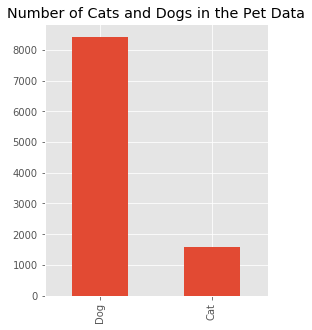

In [0]:
pd.Series(df.Species[df.PetId.unique()]).value_counts().plot(kind= 'bar',figsize=(4,5))
plt.title('Number of Cats and Dogs in the Pet Data')

<Figure size 864x360 with 0 Axes>

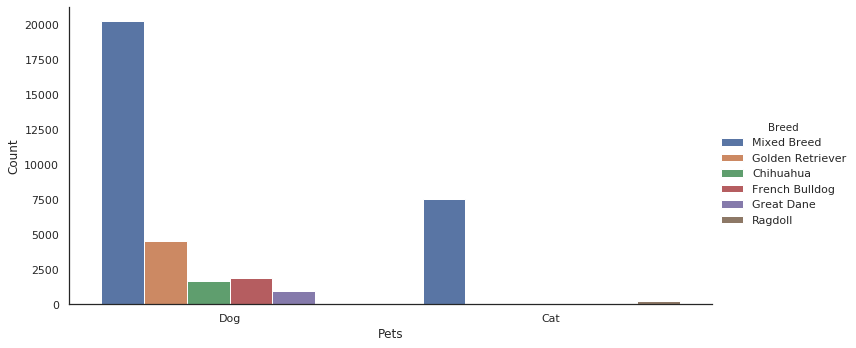

In [0]:
# Now, let's take a look at the pet species for each claim

plt.figure(figsize=(12,5))
sns.set(font_scale=1)
df2= df.drop('CancelDate', axis=1) # CancelDate also has NaN values. It causes problem while dropping NaN values

with sns.axes_style('white'):
    g = sns.catplot( 'Species', data=df2.dropna(), aspect= 2, kind='count', 
                    hue='Breed',hue_order=df['Breed'].value_counts().sort_values(ascending=False).index )
    g.set_ylabels('Count')
    g.set_xlabels('Pets')
    g.set_titles('Distrubition of Species for Each Claim')



---

#### Examining Pets' Ages

In [0]:
import plotly.express as px
fig = px.histogram(df, x="AgeAtClaim", title='Distribution of Age of Pets When There is a Claim',
                   labels={'AgeAtClaim':'Age of Pets at the Claim'})
fig.show()

As we can see from the histogram, number of claim tends to decresase after the age of 1.

*A note: This is an interactive histogram. You can see intervals and count numbers for a point when you take mouse cursor on a point

---


#####Let's check that whether how specie affects the age of pets at the claim

In [0]:
import plotly.express as px
fig = px.histogram(df, x="AgeAtClaim",color="Species", marginal="rug",
                   title='Distribution of Age of Pets When There is a Claim',
                   labels={'AgeAtClaim':'Age of Pets at the Claim'})
fig.show()

This histogram also tells that cats tend to have higher lifespan.

---


#####Now let's check how claim amount for each pet is distributed

Text(0.5, 1.0, 'Histogram for Total Claim Amount per Pet')

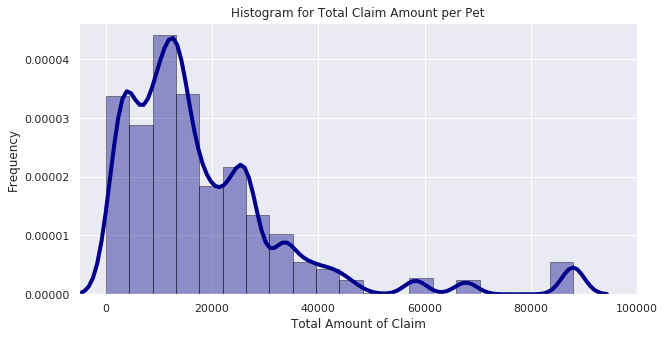

In [0]:
# Density Plot and Histogram for total claim amount
plt.figure(figsize=(10,5))
sns.distplot(df.total_amount[df.PetId.unique()], hist=True, kde=True, 
             bins=int(20), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xlim([-5000,100000])
plt.xlabel('Total Amount of Claim')
plt.ylabel('Frequency')
plt.title('Histogram for Total Claim Amount per Pet')

As we can see from the histogram, most frequent amount of total claim is around $10k-15k. Keep in mind that this histogram only shows pets that has a claim. Otherwise, zero would be the most frequent amount value!

---

##### Looking at matrix plot may give us a different perspective about the numerical data

In [0]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43022 entries, 0 to 43021
Data columns (total 10 columns):
ClaimId         37049 non-null float64
PetId           43022 non-null int64
ClaimDate       37049 non-null datetime64[ns]
ClaimAmount     37049 non-null float64
EnrollDate      43022 non-null datetime64[ns]
Species         43022 non-null object
Breed           43022 non-null object
AgeAtEnroll     43022 non-null float64
AgeAtClaim      37049 non-null float64
total_amount    43022 non-null float64
dtypes: datetime64[ns](2), float64(5), int64(1), object(2)
memory usage: 4.9+ MB


In [0]:
import plotly.express as px
fig = px.scatter_matrix(df2, width=1000, height=1000, 
                        dimensions=["AgeAtEnroll", "ClaimAmount", "AgeAtClaim", "total_amount"],
                        color= 'Species')
fig.show()


From the matrixplot, it's hard to find a strong pattern among features. We can get a second idea by checking correlation matrix. However, we can still make observations:


*   Claim amount has two outlier points. They may affect the power of the further statistical analysis negatively.
*   After age 15, we almost don't see dog claims.

---





#####Examining Correlation Matrix

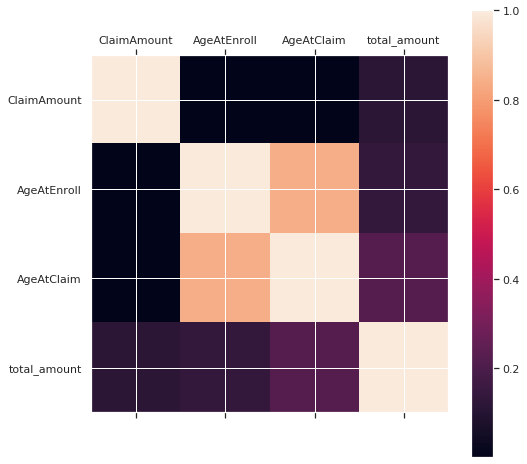

In [0]:
df3= df.drop(['PetId','ClaimId'], axis=1)
df3= df3.select_dtypes(include= 'number') 

f = plt.figure(figsize=(8,8))
plt.matshow(df3.corr(), fignum= f.number)
plt.xticks(range(len(df3.columns)), df3.columns)
plt.yticks(range(len(df3.columns)), df3.columns)
plt.colorbar()
plt.show()

The result is consistent with scatter plot matrix. There is no strong relation between features except two features. The strong positive correlation between AgeAtEnroll and AgeAtClaim is not suprising.

---





#####Examining Time Data

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43022 entries, 0 to 43021
Data columns (total 11 columns):
ClaimId         37049 non-null float64
PetId           43022 non-null int64
ClaimDate       37049 non-null datetime64[ns]
ClaimAmount     37049 non-null float64
EnrollDate      43022 non-null datetime64[ns]
CancelDate      16422 non-null datetime64[ns]
Species         43022 non-null object
Breed           43022 non-null object
AgeAtEnroll     43022 non-null float64
AgeAtClaim      37049 non-null float64
total_amount    43022 non-null float64
dtypes: datetime64[ns](3), float64(5), int64(1), object(2)
memory usage: 5.2+ MB


In [0]:
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates

plt.style.use('seaborn')

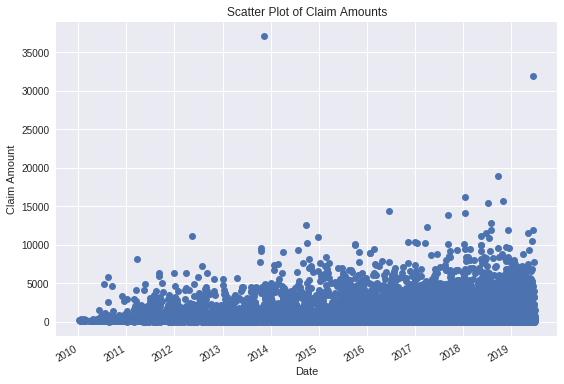

In [0]:
#df.ClaimDate.sort_values()

price_date = df['ClaimDate']
price_close = df['ClaimAmount']

plt.plot_date(price_date, price_close)

plt.gcf().autofmt_xdate()

plt.title('Scatter Plot of Claim Amounts')
plt.xlabel('Date')
plt.ylabel('Claim Amount')

plt.tight_layout()

plt.show()



---




##### Now, let's check number of claims seasonally (in terms of months)

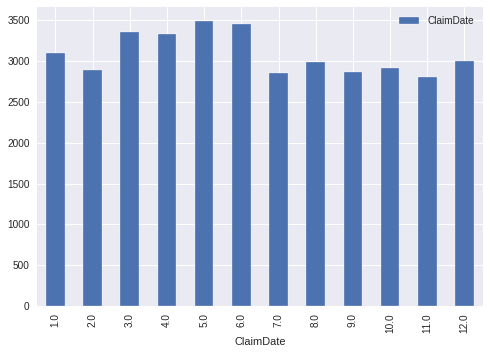

In [0]:
df[['ClaimDate']].groupby(df["ClaimDate"].dt.month).count().plot(kind="bar")

With this seasonal distritbution, we may observde that last 6 months have slightly lower values. This is probably because year 2019 only has first 6 months entries.

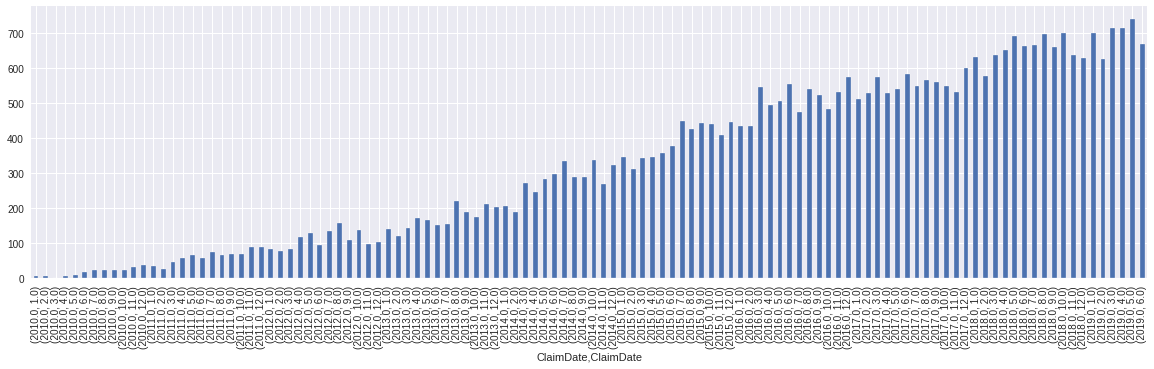

In [0]:
df.ClaimDate.groupby([df["ClaimDate"].dt.year, df["ClaimDate"].dt.month]).count().plot(kind="bar", figsize=(20,5))

In [0]:
import chart_studio.plotly as py
import plotly.graph_objs as go

import pandas as pd

##### Here is another monthly distribution of the data as time series

In [0]:
import plotly.graph_objects as go
import datetime

fig = go.Figure(data=[go.Bar(y =df.ClaimDate.groupby([df["ClaimDate"].dt.year, df["ClaimDate"].dt.month]).count())])
fig.update_layout(title_text='Time Series for Claim Amount with Rangeslider',
                  xaxis_rangeslider_visible=True)

fig.show()

By looking at this plot, we can expect that there will be around 700 claims in July 2019. As a general expectation, we can keep this in mind.

In [0]:
df["ClaimDate"].dt.month.value_counts()

5.0     3485
6.0     3459
3.0     3354
4.0     3336
1.0     3094
12.0    3004
8.0     2985
10.0    2909
2.0     2894
9.0     2863
7.0     2857
11.0    2809
Name: ClaimDate, dtype: int64

####**Creating a numerical Month data that start with 1 and ends with 114** 

In [0]:
df.ClaimDate.groupby([df["ClaimDate"].dt.year, df["ClaimDate"].dt.month]).count().shape

(114,)

In [0]:
import datetime

# I will create a datetime called date_zero. This will help me to create numerical month data
x = datetime.datetime(2009, 12, 31)
df['date_zero']=x

In [0]:
df.head()

,ClaimId,PetId,ClaimDate,ClaimAmount,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,AgeAtClaim,total_amount,date_zero
0,0.0,9273,2014-02-25,389.65,2013-01-01,2019-05-28,Dog,Mixed Breed,0.75,1.90,10628.36,2009-12-31
1,1370.0,9273,2013-08-20,221.66,2013-01-01,2019-05-28,Dog,Mixed Breed,0.75,1.38,10628.36,2009-12-31
2,1371.0,9273,2013-08-28,623.30,2013-01-01,2019-05-28,Dog,Mixed Breed,0.75,1.40,10628.36,2009-12-31
3,1596.0,9273,2013-11-26,175.66,2013-01-01,2019-05-28,Dog,Mixed Breed,0.75,1.65,10628.36,2009-12-31
4,1799.0,9273,2013-01-29,237.44,2013-01-01,2019-05-28,Dog,Mixed Breed,0.75,0.83,10628.36,2009-12-31


In [0]:
# Time to create Claim_Months data as a float type column
df["Claim_Months"] = (df.ClaimDate.dt.year - df.date_zero.dt.year) * 12 + (df.ClaimDate.dt.month - df.date_zero.dt.month) 

In [0]:
df.Claim_Months.nsmallest(10)

12902    1.0
16292    1.0
16293    1.0
16295    1.0
37022    1.0
37033    1.0
37034    1.0
12905    2.0
16294    2.0
26948    2.0
Name: Claim_Months, dtype: float64

In [0]:
df.Claim_Months.nlargest()

129     114.0
147     114.0
532     114.0
1094    114.0
1095    114.0
Name: Claim_Months, dtype: float64

In [0]:
# Let's do similar operation for enrollment date, and convert it enrollment months
df["Enrollment_Months"] = (df.EnrollDate.dt.year - df.date_zero.dt.year) * 12 + (df.EnrollDate.dt.month - df.date_zero.dt.month) 


In [0]:
# Now, we don't need date_zero column anymore. We can remove it.
df= df.drop('date_zero', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43022 entries, 0 to 43021
Data columns (total 13 columns):
ClaimId              37049 non-null float64
PetId                43022 non-null int64
ClaimDate            37049 non-null datetime64[ns]
ClaimAmount          37049 non-null float64
EnrollDate           43022 non-null datetime64[ns]
CancelDate           16422 non-null datetime64[ns]
Species              43022 non-null object
Breed                43022 non-null object
AgeAtEnroll          43022 non-null float64
AgeAtClaim           37049 non-null float64
total_amount         43022 non-null float64
Claim_Months         37049 non-null float64
Enrollment_Months    43022 non-null int64
dtypes: datetime64[ns](3), float64(6), int64(2), object(2)
memory usage: 5.8+ MB


In [0]:
df.sample(5)

,ClaimId,PetId,ClaimDate,ClaimAmount,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,AgeAtClaim,total_amount,Claim_Months,Enrollment_Months
26536,22254.0,2598,2017-08-14,311.90,2015-10-27,NaT,Cat,Ragdoll,0.75,2.55,2570.76,92.0,70
28798,22384.0,1613,2017-08-14,165.60,2014-02-05,2018-11-22,Cat,Mixed Breed,9.00,12.52,45571.63,92.0,50
9099,18601.0,3590,2015-11-07,251.85,2011-02-18,2017-03-17,Dog,Mixed Breed,0.75,5.47,9935.10,71.0,14
23573,19380.0,809,2016-07-07,790.05,2012-09-25,NaT,Dog,Mixed Breed,0.75,4.53,7045.11,79.0,33
15954,40009.0,5731,2011-05-05,454.25,2010-12-13,NaT,Dog,Mixed Breed,2.00,2.39,8719.07,17.0,12




---


##### Let's check total claim amount monthly

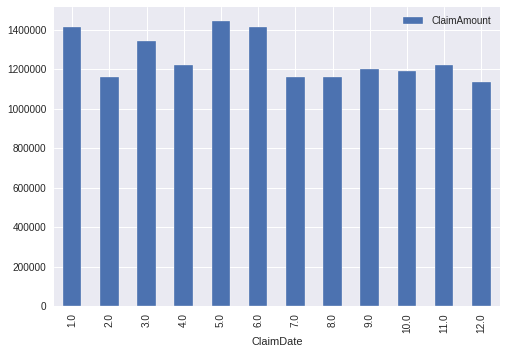

In [0]:
df[['ClaimAmount']].groupby(df["ClaimDate"].dt.month).agg('sum').plot(kind="bar")

#####Let's take a look at a Claim Amount data aggregation with a table

In [0]:
df[['ClaimAmount']].groupby(df["ClaimDate"].dt.month).agg(['sum','mean']).round(2)
 

ClaimAmount        
                  sum    mean
ClaimDate                    
1.0        1414661.53  457.23
2.0        1159469.53  400.65
3.0        1343347.41  400.52
4.0        1223736.84  366.83
5.0        1443327.68  414.15
6.0        1417501.32  409.80
7.0        1161567.41  406.57
8.0        1163154.26  389.67
9.0        1201657.22  419.72
10.0       1190283.12  409.17
11.0       1222740.67  435.29
12.0       1137669.50  378.72

Again, last 6 months tend to have lower sum than first 6 months because 2019 entries end in June.

#Filling Some Missing Values

In [0]:
# We know that AgeAtClaim has NaN values. 
# I will fill them by using 'ffill' method
# In order to use this method, same pets must be ordered consequtively.
# Therefore, I can beginwith sorting dataset according to PetID

df = df.sort_values(by='PetId')
df.head(20)

,ClaimId,PetId,ClaimDate,ClaimAmount,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,AgeAtClaim,total_amount,Claim_Months,Enrollment_Months
37049,NaN,0,NaT,NaN,2015-08-11,2018-07-13,Dog,Mixed Breed,5.00,NaN,0.00,NaN,68
37050,NaN,1,NaT,NaN,2014-02-15,2016-01-25,Cat,Mixed Breed,3.00,NaN,0.00,NaN,50
29825,35617.0,2,2016-01-08,61.06,2014-12-20,NaT,Dog,French Bulldog,0.75,1.80,2643.44,73.0,60
29824,35616.0,2,2017-06-03,63.25,2014-12-20,NaT,Dog,French Bulldog,0.75,3.20,2643.44,90.0,60
29813,7633.0,2,2018-02-14,82.80,2014-12-20,NaT,Dog,French Bulldog,0.75,3.91,2643.44,98.0,60
29814,13987.0,2,2018-08-07,190.69,2014-12-20,NaT,Dog,French Bulldog,0.75,4.38,2643.44,104.0,60
29815,24729.0,2,2018-04-14,346.61,2014-12-20,NaT,Dog,French Bulldog,0.75,4.07,2643.44,100.0,60
29826,37156.0,2,2018-06-04,278.88,2014-12-20,NaT,Dog,French Bulldog,0.75,4.21,2643.44,102.0,60
29816,25317.0,2,2018-07-14,27.25,2014-12-20,NaT,Dog,French Bulldog,0.75,4.32,2643.44,103.0,60
29818,27391.0,2,2018-06-15,162.01,2014-12-20,NaT,Dog,French Bulldog,0.75,4.24,2643.44,102.0,60




---




#####Let's reindex for PetID

In [0]:
df.reindex(df.PetId).head()

,ClaimId,PetId,ClaimDate,ClaimAmount,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,AgeAtClaim,total_amount,Claim_Months,Enrollment_Months
PetId,,,,,,,,,,,,,
0,0.0,9273,2014-02-25,389.65,2013-01-01,2019-05-28,Dog,Mixed Breed,0.75,1.90,10628.36,50.0,37
1,1370.0,9273,2013-08-20,221.66,2013-01-01,2019-05-28,Dog,Mixed Breed,0.75,1.38,10628.36,44.0,37
2,1371.0,9273,2013-08-28,623.30,2013-01-01,2019-05-28,Dog,Mixed Breed,0.75,1.40,10628.36,44.0,37
2,1371.0,9273,2013-08-28,623.30,2013-01-01,2019-05-28,Dog,Mixed Breed,0.75,1.40,10628.36,44.0,37
2,1371.0,9273,2013-08-28,623.30,2013-01-01,2019-05-28,Dog,Mixed Breed,0.75,1.40,10628.36,44.0,37


In [0]:
df.head()

,ClaimId,PetId,ClaimDate,ClaimAmount,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,AgeAtClaim,total_amount,Claim_Months,Enrollment_Months
37049,NaN,0,NaT,NaN,2015-08-11,2018-07-13,Dog,Mixed Breed,5.00,NaN,0.00,NaN,68
37050,NaN,1,NaT,NaN,2014-02-15,2016-01-25,Cat,Mixed Breed,3.00,NaN,0.00,NaN,50
29825,35617.0,2,2016-01-08,61.06,2014-12-20,NaT,Dog,French Bulldog,0.75,1.80,2643.44,73.0,60
29824,35616.0,2,2017-06-03,63.25,2014-12-20,NaT,Dog,French Bulldog,0.75,3.20,2643.44,90.0,60
29813,7633.0,2,2018-02-14,82.80,2014-12-20,NaT,Dog,French Bulldog,0.75,3.91,2643.44,98.0,60


In [0]:
#Now, we can fill missing values of AgeAtClaim column
#We will use 'ffill' method because 'ffill' propagates last valid observation forward to next valid.
# And, we ordered all values for PetID. So, same petId will be consequent and their age will also be same.
df['AgeAtClaim'] = df['AgeAtClaim'].fillna(method='ffill')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43022 entries, 37049 to 43021
Data columns (total 13 columns):
ClaimId              37049 non-null float64
PetId                43022 non-null int64
ClaimDate            37049 non-null datetime64[ns]
ClaimAmount          37049 non-null float64
EnrollDate           43022 non-null datetime64[ns]
CancelDate           16422 non-null datetime64[ns]
Species              43022 non-null object
Breed                43022 non-null object
AgeAtEnroll          43022 non-null float64
AgeAtClaim           43020 non-null float64
total_amount         43022 non-null float64
Claim_Months         37049 non-null float64
Enrollment_Months    43022 non-null int64
dtypes: datetime64[ns](3), float64(6), int64(2), object(2)
memory usage: 5.8+ MB


In [0]:
df['AgeAtClaim'] = df['AgeAtClaim'].fillna((df['AgeAtClaim'].mean()))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43022 entries, 37049 to 43021
Data columns (total 13 columns):
ClaimId              37049 non-null float64
PetId                43022 non-null int64
ClaimDate            37049 non-null datetime64[ns]
ClaimAmount          37049 non-null float64
EnrollDate           43022 non-null datetime64[ns]
CancelDate           16422 non-null datetime64[ns]
Species              43022 non-null object
Breed                43022 non-null object
AgeAtEnroll          43022 non-null float64
AgeAtClaim           43022 non-null float64
total_amount         43022 non-null float64
Claim_Months         37049 non-null float64
Enrollment_Months    43022 non-null int64
dtypes: datetime64[ns](3), float64(6), int64(2), object(2)
memory usage: 5.8+ MB


In [0]:
# ClaimID is another interesting feature. We already have PetID to identify pets.
# Therefore, we don't actually need it. We can convert ClaimID to categorical variable. 
# Pets that have a claim will be labeled as 1
# Pets that don't have a claim will be labeled as 0.
# Then, it  will named as"Any_Claim" and ClaimID column will be removed


In [0]:
df['Any_Claim'] = ['Yes' if x >= 0 else "No" for x in df['ClaimId']] 
df= df.drop('ClaimId', axis=1)

In [0]:
df.Any_Claim.value_counts()

Yes    37049
No      5973
Name: Any_Claim, dtype: int64

In [0]:
# Let's fill missing values in ClaimAmount column
df['ClaimAmount'] = df['ClaimAmount'].fillna(0)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43022 entries, 37049 to 43021
Data columns (total 13 columns):
PetId                43022 non-null int64
ClaimDate            37049 non-null datetime64[ns]
ClaimAmount          43022 non-null float64
EnrollDate           43022 non-null datetime64[ns]
CancelDate           16422 non-null datetime64[ns]
Species              43022 non-null object
Breed                43022 non-null object
AgeAtEnroll          43022 non-null float64
AgeAtClaim           43022 non-null float64
total_amount         43022 non-null float64
Claim_Months         37049 non-null float64
Enrollment_Months    43022 non-null int64
Any_Claim            43022 non-null object
dtypes: datetime64[ns](3), float64(5), int64(2), object(3)
memory usage: 5.8+ MB


In [0]:
null_values=df.isna().sum()
null_values=pd.DataFrame(null_values,columns=['null'])
sum_tot=len(df)
null_values['percent']=null_values['null']/sum_tot*100
round(null_values,3).sort_values('percent',ascending=False)

,null,percent
CancelDate,26600,61.829
ClaimDate,5973,13.884
Claim_Months,5973,13.884
PetId,0,0.000
ClaimAmount,0,0.000
EnrollDate,0,0.000
Species,0,0.000
Breed,0,0.000
AgeAtEnroll,0,0.000
AgeAtClaim,0,0.000


In [0]:
# Cancelled Pets are special case. In our previous exploration, we saw that once a plan in cancelled, the pet never made a claim.
# Therefore, I am deleting Canceldate column. Later, while making prediction from whole dataset, all their Claim_amount will be zero if there is a CancelDate.

# Secondly, ClaimDate will be dropped. Instead of claim date, 'Claim_Month' feature will be used.
# The ones, they never made a claim will also  dropped. This imformation is a serious loss for the prediction. 
# However, claim amount column compnsate this because the ones that don't have a ClaimDate have given as '0' in Any_Claim column.
df= df.drop(['CancelDate', 'ClaimDate'], axis=1)

In [0]:
# Because we already have indicator for whether there is a claim or not, I will fill missing claim_month values with "ffill" method.
# Normally, there is no claim for these pets. This isn;t the ideal way to deal with missing data for this column. 
# But, zero has a meaning for this data set. We can't use zero for NaN values for ClaimDate
# Dropping missing Claim_date them would also hurt the data. Therefore, I will use not ideal but a working method to fill missing values.
df['Claim_Months'] = df['Claim_Months'].fillna(method='ffill')
#For the missing values at the beginning of the data that 'ffill' can't fill. I will just use this one for these 2 values:
df['Claim_Months'] = df['Claim_Months'].fillna(df.Claim_Months.mean())


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43022 entries, 37049 to 43021
Data columns (total 11 columns):
PetId                43022 non-null int64
ClaimAmount          43022 non-null float64
EnrollDate           43022 non-null datetime64[ns]
Species              43022 non-null object
Breed                43022 non-null object
AgeAtEnroll          43022 non-null float64
AgeAtClaim           43022 non-null float64
total_amount         43022 non-null float64
Claim_Months         43022 non-null float64
Enrollment_Months    43022 non-null int64
Any_Claim            43022 non-null object
dtypes: datetime64[ns](1), float64(5), int64(2), object(3)
memory usage: 5.2+ MB


In [0]:
df.isna().sum()


PetId                0
ClaimAmount          0
EnrollDate           0
Species              0
Breed                0
AgeAtEnroll          0
AgeAtClaim           0
total_amount         0
Claim_Months         0
Enrollment_Months    0
Any_Claim            0
dtype: int64

###### One final feature exraction:
###### I will create two columns for claim_amounts for:
*   the last 24 months: 
*   eairler than last 24 months

In [0]:
df['Claim_Amnt_Lately'] = df.loc[df['Claim_Months'] > 90, ['ClaimAmount']]
df['Claim_Amnt'] = df.loc[df['Claim_Months'] <= 90, ['ClaimAmount']]

In [0]:
df['Claim_Amnt_Lately'] = df['Claim_Amnt_Lately'].fillna(0) 
df['Claim_Amnt'] = df['Claim_Amnt'].fillna(0) 


In [0]:
df.sample(10)

,PetId,ClaimAmount,EnrollDate,Species,Breed,AgeAtEnroll,AgeAtClaim,total_amount,Claim_Months,Enrollment_Months,Any_Claim,Claim_Amnt_Lately,Claim_Amnt
25141,3393,38.16,2011-08-01,Dog,Chihuahua,1.00,7.98,18386.75,103.0,20,Yes,38.16,0.00
40949,6540,0.00,2012-12-01,Dog,Mixed Breed,0.75,1.18,0.00,102.0,36,No,0.00,0.00
2094,6648,25.18,2015-11-27,Cat,Mixed Breed,0.75,1.08,8716.84,75.0,71,Yes,0.00,25.18
24746,538,80.65,2012-12-25,Dog,Mixed Breed,0.75,4.92,1557.88,86.0,36,Yes,0.00,80.65
24603,4228,94.18,2013-08-07,Dog,Great Dane,0.75,3.74,1092.10,80.0,44,Yes,0.00,94.18
32872,3370,865.49,2013-12-22,Cat,Mixed Breed,7.00,10.48,29902.67,90.0,48,Yes,0.00,865.49
25239,3420,87.40,2012-11-10,Dog,Mixed Breed,0.75,3.48,4676.57,68.0,35,Yes,0.00,87.40
8759,15,184.00,2013-02-11,Dog,Mixed Breed,7.00,11.17,6528.56,88.0,38,Yes,0.00,184.00
41822,8014,0.00,2018-02-10,Cat,Mixed Breed,4.00,1.14,0.00,37.0,98,No,0.00,0.00
28938,7913,14.95,2015-08-11,Cat,Mixed Breed,3.00,5.48,2626.90,98.0,68,Yes,14.95,0.00


### **Dropping remaining columns that we won't use**  


##### After this point, I will remove 'total_amount' and  'ClaimAmount' columns because they are no longer useful.  

#####We need to keep in mind that our end goal is to predict claim amount for a pet on July 2019. 

In [0]:
# We will keep exisiting df in case we need claim amounts and total_amount again.
df_before_dropping= df 


In [0]:
df= df.drop(['ClaimAmount','total_amount'], axis=1)

In [0]:
print(df.shape)
print(df.isna().sum())

(43022, 11)
PetId                0
EnrollDate           0
Species              0
Breed                0
AgeAtEnroll          0
AgeAtClaim           0
Claim_Months         0
Enrollment_Months    0
Any_Claim            0
Claim_Amnt_Lately    0
Claim_Amnt           0
dtype: int64


In [0]:
# We also won't use Enroll date as a datetime64 data. We already have enrollment_month. Thefore, EnrollDate will be removed:
df= df.drop('EnrollDate', axis=1)


---





#**Exploratory Data Analysis (EDA)**

In this section, I will apply some EDA methods in the light of information gathered by visuals. 

Here are the steps that will be followed as a beginning:


1.   Outliers will be detected
2.   By considering the results, the kind of data scaler for future analysis will be decided


Here is the theoretical background how outliers will be defined in this study:

Normally, an observation with an internally studentized residual that is larger than 3 (in absolute value) is will be deemed an outlier. By considering definition, I will define my **'anomalies'** as the data points that are at least 3 standard deviation away from the mean value. In this study, I will call them **outlier**.

In [0]:
# Let's write a function for calculation outliers (anomalies):
import numpy as np

def find_anomalies(random_data):
    anomalies = []
    # Set upper and lower limit to 3 standard deviation
    random_data_std = np.std(random_data)
    random_data_mean = np.mean(random_data)
    anomaly_cut_off = random_data_std * 3
    
    lower_limit  = random_data_mean - anomaly_cut_off 
    upper_limit = random_data_mean + anomaly_cut_off
    print('Lower limit:', round(lower_limit,2))
    print('Upper limit:', round(upper_limit,2))
    # Generate outliers
    for outlier in random_data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    return anomalies

print('Number of Outliers:', len(find_anomalies(df.AgeAtClaim)))

Lower limit: -5.97
Upper limit: 17.82
Number of Outliers: 95


Now, let's check number of influential points for total_amount and ClaimAmount

In [0]:
print('Number of Outliers:', len(find_anomalies(df.Claim_Amnt)))

Lower limit: -1697.79
Upper limit: 2077.45
Number of Outliers: 748


In [0]:
print('Number of Outliers:', len(find_anomalies(df.Enrollment_Months)))

Lower limit: -35.29
Upper limit: 132.72
Number of Outliers: 0


In [0]:
print('Number of Outliers:', len(find_anomalies(df.Claim_Amnt_Lately)))


Lower limit: -1817.92
Upper limit: 2139.25
Number of Outliers: 672


In [0]:
df.shape

(43022, 10)

Conclusion: We have considerable amount of outliers. 
*   AgeAtClaim: 95 out of 43022
*   Claim Amount in first 90 months:748 out of 43022
*   Claim Amount in last 24 months:672 out of 43022

They may harm robustness of the predictive models. Therefore, during data scaling, the effect of outliers will be reduced.


---



---



# **Machine Learning Models**

### Label Processing
In our data, there are 3 object type data. They need to be encoded.

For label processing, we will use Label encoder. 

Label processing must be done before training the data. Otherwise data leakage can happen and ruins the predictive models.

In [0]:
from sklearn import preprocessing
import pandas as pd
le = preprocessing.LabelEncoder()

df[['Species', 'Breed', 'Any_Claim']] = df[['Species', 'Breed', 'Any_Claim']].apply(le.fit_transform)




---



In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43022 entries, 37049 to 43021
Data columns (total 10 columns):
PetId                43022 non-null int64
Species              43022 non-null int64
Breed                43022 non-null int64
AgeAtEnroll          43022 non-null float64
AgeAtClaim           43022 non-null float64
Claim_Months         43022 non-null float64
Enrollment_Months    43022 non-null int64
Any_Claim            43022 non-null int64
Claim_Amnt_Lately    43022 non-null float64
Claim_Amnt           43022 non-null float64
dtypes: float64(5), int64(5)
memory usage: 4.9 MB


Split Train and Test data

In [0]:
from sklearn.model_selection import train_test_split

y= df.Claim_Amnt_Lately
X= df.drop('Claim_Amnt_Lately',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(34417, 9) (34417,)
(8605, 9) (8605,)


## Scaling the Data

In this part, we will use RobustScaler because our data has outliers and they may harm the power of the prediction model.
With RobustScaler, the influence of the outliers will be diminished.

In [0]:

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler

# Create scaler
robust_scaler = preprocessing.RobustScaler()

# Transform feature
robust_scaler.fit_transform(X_train)
robust_scaler.fit_transform(X_test)

array([[ 0.74242424, -1.        ,  0.        , ...,  0.11904762,
         0.        , -0.10743802],
       [ 1.06124627,  0.        ,  0.        , ..., -0.30952381,
         0.        ,  0.49464607],
       [-0.47609902, -1.        ,  0.        , ..., -0.69047619,
         0.        ,  0.08551922],
       ...,
       [-0.81071276, -1.        ,  0.        , ...,  0.26190476,
         0.        ,  0.11757097],
       [ 0.31327358,  0.        ,  0.        , ..., -0.88095238,
         0.        ,  2.25289256],
       [-0.83696116, -1.        ,  0.        , ...,  0.33333333,
         0.        ,  2.0190442 ]])

In [0]:
'''

# I have run all the models with StandardScaler. It didn't change anything.

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit_transform(X_train)
sc.fit_transform(X_test)

'''

"\n\n# I have run all the models with StandardScaler. It didn't change anything.\n\nfrom sklearn.preprocessing import StandardScaler\n\nsc = StandardScaler()\nsc.fit_transform(X_train)\nsc.fit_transform(X_test)\n\n"



---



---



## Performing ML Models

We need to emphasize that this study will create regression models, not classification models. Therefore, our performace evaluation metrics will be **Mean Absolute Error**, **Mean Squared Error** and 
**Root Mean Squared Error**.

### Linear Regression

In [0]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error as mse

regressor = LinearRegression() 
regressor.fit(X_train, y_train) #training the algorithm

#To retrieve the intercept:
print('Intercept Point:', regressor.intercept_)

#For retrieving the slope:
print('Cofficients:', regressor.coef_)

Intercept Point: -465.6730701664019
Cofficients: [-2.54555353e-04  1.32793321e+01 -7.43948055e+00 -5.75897759e+00
  5.10784957e+00  5.28344951e+00  7.39268740e-01  2.06855482e+02
 -4.53450294e-02]


In [0]:
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
PetId,-0.000255
Species,13.279332
Breed,-7.439481
AgeAtEnroll,-5.758978
AgeAtClaim,5.107850
Claim_Months,5.283450
Enrollment_Months,0.739269
Any_Claim,206.855482
Claim_Amnt,-0.045345


In [0]:
OLS_pred= regressor.predict(X_train)

In [0]:
from sklearn import metrics
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_train, OLS_pred),2))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_train, OLS_pred),2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_train, OLS_pred)),2))

Mean Absolute Error: 237.4
Mean Squared Error: 413955.76
Root Mean Squared Error: 643.39


####Above result's are the performance of the model at **train data**. Now, let's check performance of the OLS on **test data**

In [0]:
y_pred = regressor.predict(X_test)

df1 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1 = df1.head(25)
round(df1,2)

,Actual,Predicted
31059,44.54,336.02
35057,0.00,47.18
3345,0.00,194.85
1975,0.00,146.42
6516,484.25,358.27
34672,0.00,150.21
6307,0.00,177.35
3404,341.32,383.70
25584,0.00,10.67
8311,0.00,196.05


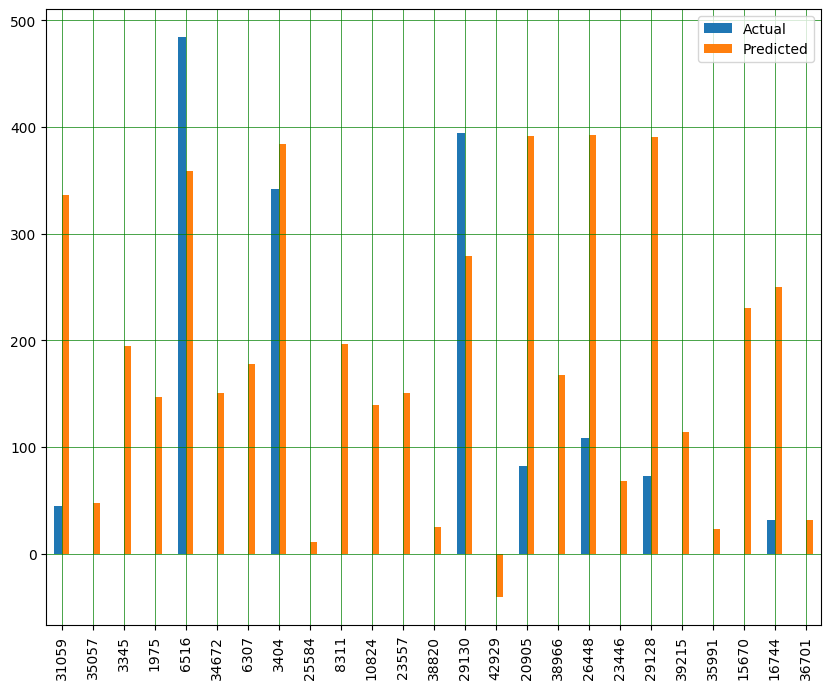

In [0]:
import matplotlib as mpl
%matplotlib inline
plt.style.use('default')

df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

By considreting this graph, it's easy to guess that performance of OLS must be low. We can see this poor prediction performance by looking at r-squared value:

In [0]:
R_squared = regressor.score(X_test,y_test)
print('R_squared = ', R_squared*100,'%')

R_squared =  6.305184850457513 %


####Evaluate power of OLS prediction on test data

In [0]:
y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred),2))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred),2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),2))

Mean Absolute Error: 230.98
Mean Squared Error: 383749.43
Root Mean Squared Error: 619.48


For the train data:
*   Mean Absolute Error: 237.4
*   Mean Squared Error: 413955.76
*   Root Mean Squared Error: 643.393

When we compare the performance metrics with test data for linear regression, we can observe that the test data does slightly better prediction. This also shows that we don't have overfitting problem here.

Keep in mind that these performance metrics doe't tell much just by themselves. We will compare performance of the models. 

**Ridge Regression**

Text(0, 0.5, 'weights')

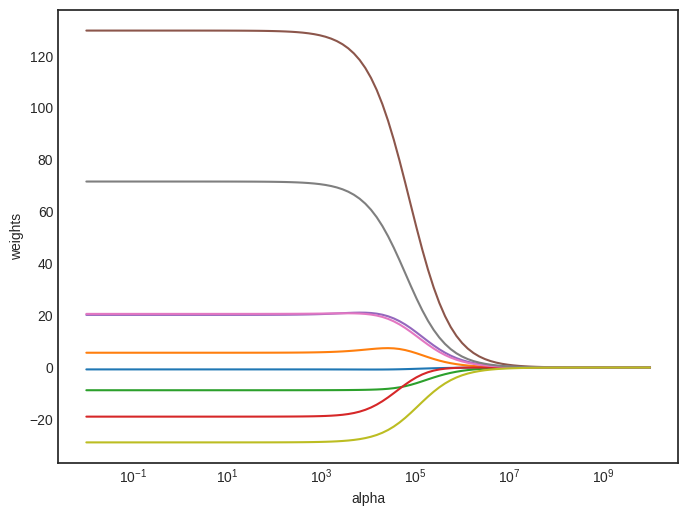

In [0]:
alphas = 10**np.linspace(10,-2,100)*0.5

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from sklearn.preprocessing import scale 

%matplotlib inline
plt.style.use('seaborn-white')

from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=100)

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

clf= Ridge()
coefs = []

for a in alphas:
    clf.set_params(alpha=a)
    clf.fit(scale(X_train), y_train)
    coefs.append(clf.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [0]:
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.005

Finally, we refit our ridge regression model on the full data set, using the value of alpha chosen by cross-validation, and examine the coefficient estimates.

In [0]:
# Fit a ridge regression on the training data
pred2 = ridgecv.predict(X_test)
# Use this model to predict the test data
print(pd.Series(ridgecv.coef_, index = X.columns))

PetId                 -0.000256
Species               13.440624
Breed                 -7.433068
AgeAtEnroll           -5.739599
AgeAtClaim             5.138091
Claim_Months           5.255804
Enrollment_Months      0.741088
Any_Claim            205.784055
Claim_Amnt            -0.045242
dtype: float64


In [0]:
#Model's performace evaluation:
from sklearn import metrics
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, pred2),2))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, pred2),2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, pred2)),2))

Mean Absolute Error: 230.71
Mean Squared Error: 383742.39
Root Mean Squared Error: 619.47


#####Checking Feature Importance

Text(0.5, 1.0, 'Feature importance using Ridge Model')

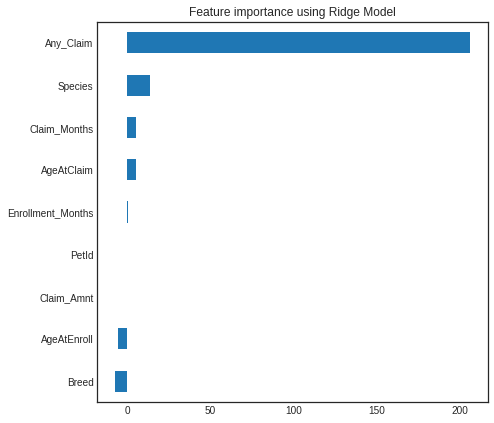

In [0]:
coef_ridge= pd.Series(ridgecv.coef_, index = X.columns)
imp_coef = coef_ridge.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (7.0, 7.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Ridge Model")

## **LASSO**

No handles with labels found to put in legend.


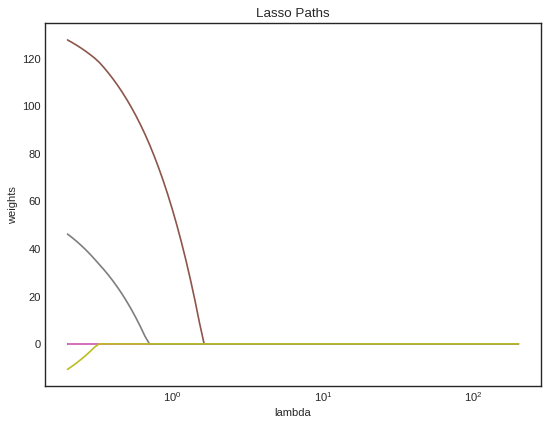

In [0]:
from sklearn.linear_model import Lasso
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from sklearn import linear_model
from sklearn import datasets
from sklearn.preprocessing import scale 

%matplotlib inline
plt.style.use('seaborn-white')
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80)

lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []
alphas= np.logspace(-1,2,100)
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('weights')
plt.title('Lasso Paths')
plt.legend()

In [0]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn import metrics

reg = LassoCV( alphas = None, cv = 10, max_iter = 100000, normalize = True)
reg.fit(X_train, y_train)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X_train,y_train))
coef = pd.Series(reg.coef_, index = X.columns)
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, reg.predict(X_test))),2))

Best alpha using built-in LassoCV: 0.001309
Best score using built-in LassoCV: 0.062010
Root Mean Squared Error: 619.47


In [0]:
reg.alpha_

0.001309067049657687

In [0]:
coef

PetId                 -0.000172
Species               12.833023
Breed                 -7.333702
AgeAtEnroll           -5.282073
AgeAtClaim             4.633546
Claim_Months           5.311926
Enrollment_Months      0.698180
Any_Claim            205.399539
Claim_Amnt            -0.044999
dtype: float64

In [0]:
coeff_used = np.sum(reg.coef_!=0)
print ("number of features used: ", coeff_used)

number of features used:  9


Visual for Feature Importance

Text(0.5, 1.0, 'Feature importance using Lasso Model')

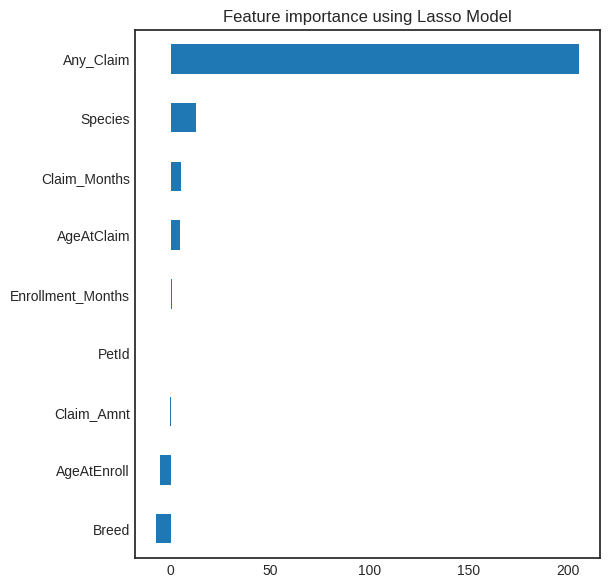

In [0]:
imp_coef = coef.sort_values()
import matplotlib
#matplotlib.rcParams['figure.figsize'] = (6.0, 7.0)
figure(num=None, figsize=(6, 7), dpi=100)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

According to Lasso, we have three important predictors: **Claim_Month,
 Enrollment_Months and Claim_Amnt**

In [0]:
#Performace evaluation of the Model
y_pred = reg.predict(X_test)

print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred),2))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred),2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),2))

Mean Absolute Error: 230.83
Mean Squared Error: 383744.27
Root Mean Squared Error: 619.47


#####Lasso's performance is almost same with Ridge Regression

Ridge Regression results were:
*   Mean Absolute Error: 230.71
*   Mean Squared Error: 383742.39
*   Root Mean Squared Error: 619.47

---





# KNN

Normally, KNN can put a serious computatinal power stress on computers. However, for this data, it won't be an issue because our data is so small. In bigger and higher dimensinal data, this concern needs to be considered.

In [0]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import pairwise_distances
from sklearn import neighbors
from math import sqrt
from sklearn.metrics import mean_squared_error 

In [0]:
rmse_val2 = [] #to store rmse values for different k
for K in range(15):
    K += 1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test, pred)) #calculate rmse
    rmse_val2.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 773.1732516682973
RMSE value for k=  2 is: 698.00411690179
RMSE value for k=  3 is: 651.5063282860433
RMSE value for k=  4 is: 634.9700766556681
RMSE value for k=  5 is: 628.2682079692369
RMSE value for k=  6 is: 621.3936287399084
RMSE value for k=  7 is: 618.9831217096604
RMSE value for k=  8 is: 615.7384147129548
RMSE value for k=  9 is: 611.8946877930742
RMSE value for k=  10 is: 610.7985188538914
RMSE value for k=  11 is: 610.4673639409904
RMSE value for k=  12 is: 609.4403702935442
RMSE value for k=  13 is: 608.7337037459142
RMSE value for k=  14 is: 608.5608072590542
RMSE value for k=  15 is: 608.3016888228075


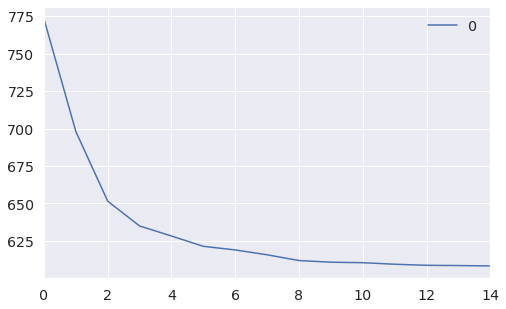

In [0]:
#plotting the rmse values against k values
import seaborn as sns

sns.set(font_scale=1.3)

curve = pd.DataFrame(rmse_val2) #elbow curve 
curve.plot(figsize=(8,5))

######This means that we can make the best prediction by looking at two, three or five nearest neighbors of a data point. The number depends on the insight of the researcher. For this study, I prefer the moderately simpler model which is looking at three nearest neighbors. If my data would be too big and high dimensinonal, I would go with K=2.

*Then, lets generating a model for K=3* 
--


In [0]:
#Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsRegressor

#Create KNN Classifier
knn = KNeighborsRegressor(n_neighbors=3)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

##### Model evaluation

In [0]:
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred),2))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred),2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),2))

Mean Absolute Error: 190.86
Mean Squared Error: 424460.5
Root Mean Squared Error: 651.51


Compared to Lasso, MAE is better but MSE and RMSE values are worse.

---



---



# **XGBOOST**

In [0]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np


xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

[10:37:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 629.707139


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



In [0]:
# fit model
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train,y_train)

predictions = xg_reg.predict(X_test)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[10:37:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Model Evaluation

In [0]:
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, predictions),2))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, predictions),2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, predictions)),2))

Mean Absolute Error: 182.09
Mean Squared Error: 396531.08
Root Mean Squared Error: 629.71


##K-fold Cross Validation using XGBoost

In [0]:
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 3, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[10:37:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:37:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:37:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



##### Now, 3-fold cross validation will performed. **Max depth is chosen as 3**. So that the model will be kept simple. 

In [0]:
A, b = X.iloc[:,:-1],X.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data=A,label=b)

params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 3, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



[10:37:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:37:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:37:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,651.507914,14.548330,651.079081,28.823639
1,646.672852,14.211239,646.244649,29.446922
2,642.091573,14.104366,641.730428,29.686853
3,637.453430,12.855944,637.160970,31.312135
4,634.509867,12.596079,634.216308,31.695085


In [0]:
print((cv_results["test-rmse-mean"]).tail(1))

49    602.371358
Name: test-rmse-mean, dtype: float64


In [0]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[10:37:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


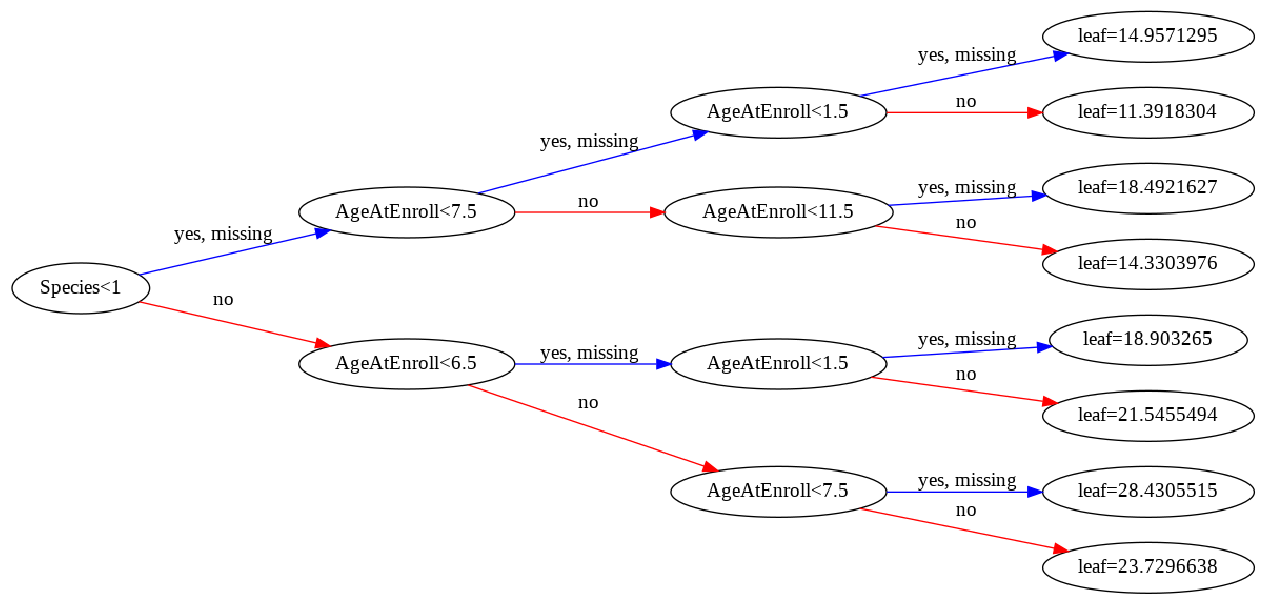

In [0]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,rankdir='LR', num_trees=0)
plt.rcParams['figure.figsize'] = [20,20]
plt.show()

### Another way for looking at same tree

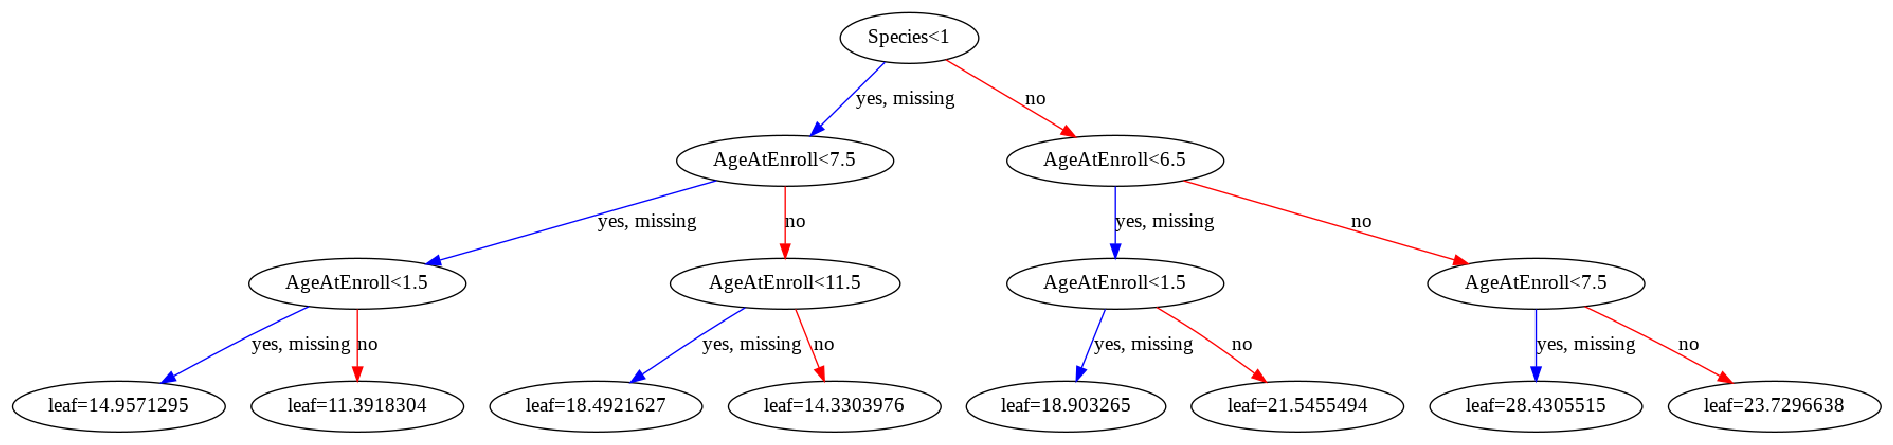

In [0]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [30,40]
plt.show()

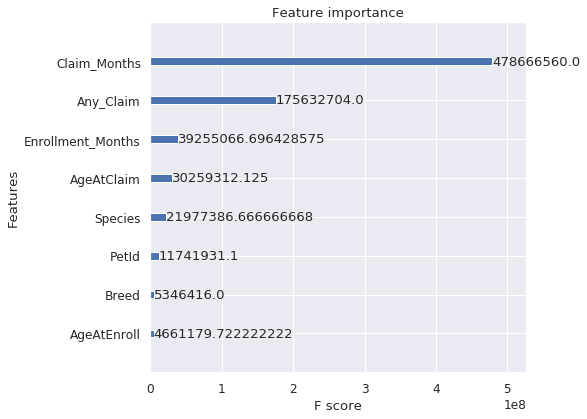

In [0]:
import seaborn as sns
xgb.plot_importance(xg_reg, importance_type= 'gain')
sns.set(font_scale=1.1)
plt.rcParams['figure.figsize'] = [6,6]
plt.show()

XGBoost is a specific implementation of the Gradient Boosting method which uses more accurate approximations to find the best tree model. It employs a number of nifty tricks that make it exceptionally successful, particularly with structured data. XGBoost has additional advantages: training is very fast and can be parallelized / distributed across clusters. 

This feature importance plot tells which features are important. On the other hand, there are a different importance type methods for this plot. In case the plot doesn't make sense, we can try other importance types. Available importance types are:

importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

---



---




## **Random Forest**

In [0]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=20, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [0]:
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred),2))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred),2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),2))

Mean Absolute Error: 169.01
Mean Squared Error: 378752.05
Root Mean Squared Error: 615.43


Let's increase number of tress from 20 to 200

In [0]:
regressor = RandomForestRegressor(n_estimators=200, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [0]:
print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred),2))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred),2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)),2))

Mean Absolute Error: 165.97
Mean Squared Error: 370375.53
Root Mean Squared Error: 608.58


With more trees, the model RMSE has slightly get better **(615.43 vs 608.58)**

We will go with 200 trees

### **Visulization**


In [0]:
# Visualizing a Single Decision Tree

# Import tools needed for visualization
rf= regressor
features= df.drop('Claim_Amnt_Lately', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

In [0]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(X_train, y_train)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot',
                feature_names = feature_list, rounded = True, precision = 1, proportion = False, filled= True)

(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

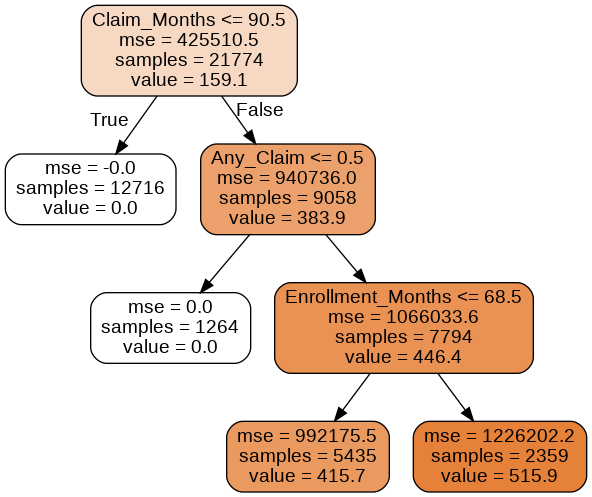

In [0]:
# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'small_tree.png')

In [0]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: AgeAtClaim           Importance: 0.42
Variable: Claim_Months         Importance: 0.24
Variable: PetId                Importance: 0.17
Variable: Enrollment_Months    Importance: 0.09
Variable: AgeAtEnroll          Importance: 0.03
Variable: Any_Claim            Importance: 0.03
Variable: Breed                Importance: 0.02
Variable: Species              Importance: 0.01
Variable: Claim_Amnt           Importance: 0.0


[None, None, None, None, None, None, None, None, None]

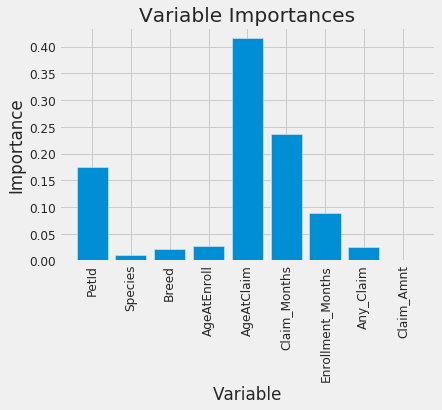

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

#hue='Breed',hue_order=df['Breed'].value_counts().sort_values(ascending=False).index

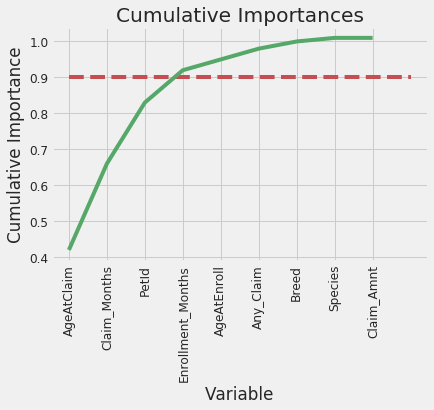

In [0]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 90% of importance retained
plt.hlines(y = 0.90, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance');
plt.title('Cumulative Importances');

In [0]:
# Find number of features for cumulative importance of 90%

# Add 1 because Python is zero-indexed
print('Number of features for 90% importance:', np.where(cumulative_importances > 0.90)[0][0] + 1)

Number of features for 90% importance: 4


### **New Random Forest with the most important seven features**

In [0]:
# New random forest with only the most important variables
from sklearn.ensemble import RandomForestRegressor
rf_most_important = RandomForestRegressor(n_estimators=200, random_state=0)

In [0]:
# Extract the most important features
features= df.drop('Claim_Amnt_Lately', axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)


In [0]:
important_indices= ['AgeAtClaim','Claim_Months','PetId', 'Enrollment_Months']
train_important = X_train.loc[:, important_indices]
test_important = X_test.loc[:, important_indices]

rf_most_important.fit(train_important, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

Make pedictions with this filtered model

In [0]:
predictions = rf_most_important.predict(test_important)

print('Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, predictions),2))
print('Mean Squared Error:', round(metrics.mean_squared_error(y_test, predictions),2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, predictions)),2))

Mean Absolute Error: 176.45
Mean Squared Error: 372243.53
Root Mean Squared Error: 610.12


Full model's performace(for comparison)
*   Mean Absolute Error: 165.97
*   Mean Squared Error: 370375.53
*   Root Mean Squared Error: 608.58

The reduced model's RMSE is slightly better than the full model. Keep in mind that, this performances were obtained just by using 4 features instead of 9. Therefore, it can be considered as an improvement in both model performance and computational efficiency.

The important features for the prediction are: 
**'AgeAtClaim', 'Claim_Months', 'PetId', and 'Enrollment_Months'**



---



# **Model Comparison**

**Linear Regression:**

*   Mean Absolute Error: 230.98
*   Mean Squared Error: 383749.43
*   Root Mean Squared Error: 619.48


**Ridge Regression** :
*   Mean Absolute Error: 230.71
*   Mean Squared Error: 383742.39
*   Root Mean Squared Error: 619.47


**Lasso** :
*   Mean Absolute Error: 230.83
*   Mean Squared Error: 383744.27
*   Root Mean Squared Error: 619.47


**KNN** :
*   Mean Absolute Error: 190.86
*   Mean Squared Error: 424460.5
*   Root Mean Squared Error: 651.51


**XGB** :
*   Mean Absolute Error: 182.09
*   Mean Squared Error: 396531.08
*   Root Mean Squared Error: 629.71


**Random Forest** :
*   Mean Absolute Error: 176.45
*   Mean Squared Error: 372243.53
*   Root Mean Squared Error: 610.12


-----------
When we compare the models, we can see that **Random Forest** has lowest MAE, MSE and RMSE. 

Lasso also does a good job on prediction. However, in all three metrics, Ramdom Forest is performing best. Therefore, we can easily will go with **Random Forest** as best predictive model for our data.



---

Without any scaler, only XGB performance has improved slightly. This is still not better than random forest. Others stayed exactly the same. 

**XGB without any scaler** :
*   Mean Absolute Error: 182.09
*   Mean Squared Error: 396531.08
*   Root Mean Squared Error: 629.71






### **Now, it's time to make prediction for July 2019 with Random Forest**

 *  In order to make prediction for July 2019, I will use all the data for fitting the model. That's why, we won't have the Claim_Amnt_Lately column as a seperate column.

*   For prediction, we will create a new dataframe that will include four predictors suggest by Random Forest model, which are:  **'AgeAtClaim', 'Claim_Months', 'PetId', and 'Enrollment_Months'**.

*   We will predict claim amount at  **July 2019**. So, the column will be named as  **Claim_Amount_July_2019**. Then, Claim_Months coulmns will be re-created. The new Claim_Months will have only one value: to 115 which (Remember that our data, the last claim month is 114, which indicates June 2019).

*   For prediction, I will recalculate AgeAtClaim and use it. The other two predictors PetID and Enrollment_Months won't be affected from the change in Claim_Months. So, they will stay same.

*   After making prediction, cancel date will be taken into consideration. For the Pets that have a CancelDate, their Claim_Amount will be zero. Remember that in the original data, there was no claim after a CancelDate.

y= df.Claim_Amnt_Lately
X= df.drop('Claim_Amnt_Lately',axis=1)

# **Creating New Dataframe for Predicting July 2019 Claim Amount and Pre-Processing the New Df**



*   We remember that **df** data is already a pre-processed data.
*   This time there won't be splitting as train, test data.
*   List item

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
#Pick required columns from df
df_new= df[['AgeAtClaim','Claim_Months','PetId', 'Enrollment_Months']]

**Calculate age at July 2019** 

In order to do it, we will follow these steps:

*   Calculate the montly difference between claimdate and July 2019 as 
*   Convert the difference yearly by dividing it by 12
*   Add this different to the AgeAtClaim.



In [0]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

df_new['July_2019_claims']= 115 # Months are in an order. And, in the df last month June 2019's number is 114.

month_difference= df_new.July_2019_claims - df_new.Claim_Months

yearly_age_diff= month_difference/12
yearly_age_diff.nsmallest(10)

1895     0.083333
20641    0.083333
19937    0.083333
37114    0.083333
37115    0.083333
20400    0.083333
17654    0.083333
22375    0.083333
37151    0.083333
37152    0.083333
dtype: float64

In [0]:
yearly_age_diff.nlargest(10)

12902    9.500000
37033    9.500000
37034    9.500000
37022    9.500000
16295    9.500000
16292    9.500000
16293    9.500000
42541    9.500000
26948    9.416667
12905    9.416667
dtype: float64

In [0]:
Age_at_July_2019= yearly_age_diff + df.AgeAtClaim
df_new['AgeAtClaim']= Age_at_July_2019
df_new['AgeAtClaim'].head()

37049    8.797893
37050    8.797893
29825    5.300000
29824    5.283333
29813    5.326667
Name: AgeAtClaim, dtype: float64

In [0]:
df_new.AgeAtClaim.nlargest(10)

16790    22.456667
16784    22.450000
16794    22.446667
16795    22.446667
16796    22.446667
16783    22.440000
16801    22.440000
16789    22.436667
16798    22.433333
16793    22.426667
Name: AgeAtClaim, dtype: float64

In [0]:
df_new.sample()

,AgeAtClaim,Claim_Months,PetId,Enrollment_Months,July_2019_claims
18690,6.433333,69.0,4119,47,115


In [0]:
df_new['Claim_Months']= df_new['July_2019_claims']
df_new.sample(5)

,AgeAtClaim,Claim_Months,PetId,Enrollment_Months,July_2019_claims
27732,9.680000,115,8961,8,115
32932,12.286667,115,5828,40,115
3328,7.206667,115,5332,37,115
8491,11.933333,115,5997,68,115
13588,9.610000,115,8482,9,115


In [0]:
df_new= df_new.drop('July_2019_claims', axis=1)

In [0]:
# And, let's check df_new data that we created for prediction
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43022 entries, 37049 to 43021
Data columns (total 4 columns):
AgeAtClaim           43022 non-null float64
Claim_Months         43022 non-null int64
PetId                43022 non-null int64
Enrollment_Months    43022 non-null int64
dtypes: float64(1), int64(3)
memory usage: 2.9 MB


# **Now, we can deploy the model and make prediction**

In [0]:
# We will use df_before_dropping and call it df_total data because it has the 'ClaimAmount' feature for all pets
# We are doing this because we will change df_total in future operations. In case we need df_before_dropping, it must be kept same.
df_total= df_before_dropping
df_total.sample()

,PetId,ClaimAmount,EnrollDate,Species,Breed,AgeAtEnroll,AgeAtClaim,total_amount,Claim_Months,Enrollment_Months,Any_Claim,Claim_Amnt_Lately,Claim_Amnt
13183,7302,298.33,2013-12-04,Dog,Chihuahua,0.75,4.07,2144.21,87.0,48,Yes,0.0,298.33


In [0]:
#Let's scale the data


from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler

# Create scaler
robust_scaler = preprocessing.RobustScaler()

# Transform feature
robust_scaler.fit_transform(df_new)
robust_scaler.fit_transform(df_total[['AgeAtClaim','Claim_Months','PetId', 'Enrollment_Months']])


array([[ 0.11994323, -0.12381386, -1.06235218,  0.48780488],
       [ 0.11994323, -0.12381386, -1.06213717,  0.04878049],
       [-0.55211726, -0.33333333, -1.06192217,  0.29268293],
       ...,
       [-0.61889251, -0.16666667,  1.08729306,  0.56097561],
       [-0.64006515, -0.22222222,  1.08729306,  0.56097561],
       [-0.64006515, -0.22222222,  1.08750806,  0.65853659]])

**Random Forest** 

In [0]:
# New random forest with only the most important variables
from sklearn.ensemble import RandomForestRegressor
rf_most_important = RandomForestRegressor(n_estimators=200, random_state=0)

In [0]:
# Extract the most important features
features= df_total.drop('ClaimAmount', axis = 1)
y= df_total['ClaimAmount']
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)


In [0]:
important_indices= ['AgeAtClaim','Claim_Months','PetId', 'Enrollment_Months']
train_important = df_total.loc[:, important_indices]
test_important = df_new.loc[:, important_indices]

rf_most_important.fit(train_important, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [0]:
predictions = rf_most_important.predict(test_important)
predictions.shape

(43022,)

In [0]:
#Let's add random forest predictions for July 2019 as a new column
df_total['Claim_Amount_July2019']= predictions
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43022 entries, 37049 to 43021
Data columns (total 14 columns):
PetId                    43022 non-null int64
ClaimAmount              43022 non-null float64
EnrollDate               43022 non-null datetime64[ns]
Species                  43022 non-null object
Breed                    43022 non-null object
AgeAtEnroll              43022 non-null float64
AgeAtClaim               43022 non-null float64
total_amount             43022 non-null float64
Claim_Months             43022 non-null float64
Enrollment_Months        43022 non-null int64
Any_Claim                43022 non-null object
Claim_Amnt_Lately        43022 non-null float64
Claim_Amnt               43022 non-null float64
Claim_Amount_July2019    43022 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(2), object(3)
memory usage: 6.2+ MB


In [0]:
df_total.info() #Let's remember what was df_tatol data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43022 entries, 37049 to 43021
Data columns (total 14 columns):
PetId                    43022 non-null int64
ClaimAmount              43022 non-null float64
EnrollDate               43022 non-null datetime64[ns]
Species                  43022 non-null object
Breed                    43022 non-null object
AgeAtEnroll              43022 non-null float64
AgeAtClaim               43022 non-null float64
total_amount             43022 non-null float64
Claim_Months             43022 non-null float64
Enrollment_Months        43022 non-null int64
Any_Claim                43022 non-null object
Claim_Amnt_Lately        43022 non-null float64
Claim_Amnt               43022 non-null float64
Claim_Amount_July2019    43022 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(2), object(3)
memory usage: 6.2+ MB


In [0]:
# I will evalutate the data per/pet anymore. Let's make some preparations for it.
df_total['Claim_Amount_July2019']= df_total.groupby('PetId').Claim_Amount_July2019.transform('mean')

In [0]:
df_merged= df_claim.merge(df_pet, on='PetId', how='right')
df_merged.head()

,ClaimId,PetId,ClaimDate,ClaimAmount,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll
0,0.0,9273,2014-02-25,389.65,2013-01-01,2019-05-28,Dog,Mixed Breed,8 weeks to 12 months old
1,1370.0,9273,2013-08-20,221.66,2013-01-01,2019-05-28,Dog,Mixed Breed,8 weeks to 12 months old
2,1371.0,9273,2013-08-28,623.30,2013-01-01,2019-05-28,Dog,Mixed Breed,8 weeks to 12 months old
3,1596.0,9273,2013-11-26,175.66,2013-01-01,2019-05-28,Dog,Mixed Breed,8 weeks to 12 months old
4,1799.0,9273,2013-01-29,237.44,2013-01-01,2019-05-28,Dog,Mixed Breed,8 weeks to 12 months old


In [0]:
df_merged['total_claim_until_June']= df_claim.groupby('PetId').ClaimAmount.transform('sum')
df_merged= df_merged.drop_duplicates(['PetId']) # Drop duplicate PetId values
df_total_per_pet= df_total.drop_duplicates(['PetId']) # Drop duplicate PetId values

print(df_merged.shape)
print(df_total_per_pet.shape)

(10000, 10)
(10000, 14)


In [0]:
df_prediction = df_merged.merge(df_total_per_pet[['PetId','Claim_Amount_July2019']], on='PetId', how='right')
df_prediction.shape

(10000, 11)

In [0]:
df_prediction.head()

,ClaimId,PetId,ClaimDate,ClaimAmount,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,total_claim_until_June,Claim_Amount_July2019
0,0.0,9273,2014-02-25,389.65,2013-01-01,2019-05-28,Dog,Mixed Breed,8 weeks to 12 months old,10628.36,1683.005643
1,1.0,1988,2014-03-10,455.40,2013-11-24,NaN,Dog,Golden Retriever,8 weeks to 12 months old,4488.30,330.226552
2,2.0,2452,2014-04-02,1953.79,2013-03-11,2017-08-08,Dog,Mixed Breed,8 weeks to 12 months old,14240.36,532.085500
3,3.0,3658,2014-04-05,243.74,2009-11-22,2019-01-10,Dog,Mixed Breed,8 weeks to 12 months old,5310.95,325.967015
4,5.0,9147,2014-03-18,206.42,2011-12-16,2017-05-16,Dog,Mixed Breed,6 years old,11139.80,760.855503


In [0]:
#df_prediction= df_prediction.drop(['Claim_Amount_July2019_x','Claim_Amount_July2019_y', axis=1])

In [0]:
df_prediction.Claim_Amount_July2019.shape

(10000,)

In [0]:
df_prediction.PetId.sort_values()

4027       0
4028       1
2010       2
4029       3
3845       4
        ... 
1142    9995
3952    9996
9998    9997
1223    9998
9999    9999
Name: PetId, Length: 10000, dtype: int64

**Now, let's make all Claim Amout of July 2019 for canceled plans zero.**

In [0]:
df_prediction['Claim_Amount_July2019'] = np.where((df_prediction.CancelDate.notnull()), 0, df_prediction.Claim_Amount_July2019).round(2)
df_prediction

,ClaimId,PetId,ClaimDate,ClaimAmount,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,total_claim_until_June,Claim_Amount_July2019
0,0.0,9273,2014-02-25,389.65,2013-01-01,2019-05-28,Dog,Mixed Breed,8 weeks to 12 months old,10628.36,0.00
1,1.0,1988,2014-03-10,455.40,2013-11-24,NaN,Dog,Golden Retriever,8 weeks to 12 months old,4488.30,330.23
2,2.0,2452,2014-04-02,1953.79,2013-03-11,2017-08-08,Dog,Mixed Breed,8 weeks to 12 months old,14240.36,0.00
3,3.0,3658,2014-04-05,243.74,2009-11-22,2019-01-10,Dog,Mixed Breed,8 weeks to 12 months old,5310.95,0.00
4,5.0,9147,2014-03-18,206.42,2011-12-16,2017-05-16,Dog,Mixed Breed,6 years old,11139.80,0.00
...,...,...,...,...,...,...,...,...,...,...,...
9995,NaN,9989,NaN,NaN,2013-06-12,2013-12-12,Dog,Mixed Breed,2 years old,NaN,0.00
9996,NaN,9990,NaN,NaN,2018-06-28,NaN,Cat,Ragdoll,8 weeks to 12 months old,NaN,499.50
9997,NaN,9993,NaN,NaN,2019-09-17,NaN,Cat,Mixed Breed,9 years old,NaN,1324.35
9998,NaN,9997,NaN,NaN,2015-01-14,2015-03-11,Dog,Mixed Breed,8 weeks to 12 months old,NaN,0.00


In [0]:
#Let's check the data
df_prediction.loc[df_prediction.CancelDate.notnull()].sample(10)

,ClaimId,PetId,ClaimDate,ClaimAmount,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,total_claim_until_June,Claim_Amount_July2019
7911,NaN,6510,NaN,NaN,2012-04-12,2015-04-10,Cat,Mixed Breed,8 weeks to 12 months old,NaN,0.0
9942,NaN,9904,NaN,NaN,2010-02-05,2011-09-30,Dog,Mixed Breed,5 years old,NaN,0.0
3628,27786.0,8066,2014-12-15,747.5,2014-11-28,2015-02-02,Cat,Mixed Breed,7 years old,27056.85,0.0
9640,NaN,9385,NaN,NaN,2015-09-21,2015-10-05,Cat,Mixed Breed,4 years old,NaN,0.0
7989,NaN,6647,NaN,NaN,2019-05-31,2019-06-07,Dog,Mixed Breed,9 years old,NaN,0.0
6181,NaN,3538,NaN,NaN,2017-11-28,2018-02-22,Cat,Mixed Breed,4 years old,NaN,0.0
6469,NaN,4047,NaN,NaN,2015-05-31,2016-01-02,Dog,Mixed Breed,8 weeks to 12 months old,NaN,0.0
9321,NaN,8845,NaN,NaN,2018-10-06,2019-05-09,Cat,Mixed Breed,1 year old,NaN,0.0
9208,NaN,8665,NaN,NaN,2015-04-03,2017-03-30,Dog,Mixed Breed,8 weeks to 12 months old,NaN,0.0
5018,NaN,1654,NaN,NaN,2015-08-20,2016-07-20,Dog,Mixed Breed,8 weeks to 12 months old,NaN,0.0


In [0]:
df_prediction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 11 columns):
ClaimId                   4027 non-null float64
PetId                     10000 non-null int64
ClaimDate                 4027 non-null object
ClaimAmount               4027 non-null float64
EnrollDate                10000 non-null object
CancelDate                4879 non-null object
Species                   10000 non-null object
Breed                     10000 non-null object
AgeAtEnroll               10000 non-null object
total_claim_until_June    4027 non-null float64
Claim_Amount_July2019     10000 non-null float64
dtypes: float64(4), int64(1), object(6)
memory usage: 937.5+ KB


In [0]:
df_prediction.sample(20)

,ClaimId,PetId,ClaimDate,ClaimAmount,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,total_claim_until_June,Claim_Amount_July2019
5096,NaN,1786,NaN,NaN,2019-01-13,NaN,Dog,Golden Retriever,8 weeks to 12 months old,NaN,148.76
3861,34155.0,9015,2018-12-24,56.35,2014-02-11,NaN,Cat,Mixed Breed,8 weeks to 12 months old,50796.51,659.61
6499,NaN,4107,NaN,NaN,2019-04-12,NaN,Dog,Mixed Breed,8 weeks to 12 months old,NaN,44.79
1089,2796.0,6830,2019-05-14,119.48,2016-12-11,2019-06-13,Cat,Mixed Breed,5 years old,12441.41,0.00
7085,NaN,5075,NaN,NaN,2010-11-02,2012-06-19,Cat,Mixed Breed,12 years old,NaN,0.00
4170,NaN,239,NaN,NaN,2018-11-16,NaN,Cat,Mixed Breed,2 years old,NaN,153.79
8665,NaN,7784,NaN,NaN,2017-08-07,NaN,Cat,Mixed Breed,1 year old,NaN,696.35
6786,NaN,4575,NaN,NaN,2012-03-09,NaN,Cat,Mixed Breed,2 years old,NaN,38.08
7360,NaN,5540,NaN,NaN,2015-07-04,NaN,Cat,Mixed Breed,7 years old,NaN,12.39
6389,NaN,3906,NaN,NaN,2009-11-24,2013-04-11,Cat,Mixed Breed,8 weeks to 12 months old,NaN,0.00


In [0]:
df_prediction.Claim_Amount_July2019.value_counts()

0.00       4885
34.78         5
1286.14       5
23.23         4
1323.72       4
           ... 
582.85        1
179.03        1
261.85        1
147.97        1
694.07        1
Name: Claim_Amount_July2019, Length: 4902, dtype: int64

In [0]:
df_prediction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 11 columns):
ClaimId                   4027 non-null float64
PetId                     10000 non-null int64
ClaimDate                 4027 non-null datetime64[ns]
ClaimAmount               4027 non-null float64
EnrollDate                10000 non-null datetime64[ns]
CancelDate                4879 non-null datetime64[ns]
Species                   10000 non-null object
Breed                     10000 non-null object
AgeAtEnroll               10000 non-null object
total_claim_until_June    4027 non-null float64
Claim_Amount_July2019     10000 non-null float64
dtypes: datetime64[ns](3), float64(4), int64(1), object(3)
memory usage: 937.5+ KB


# **Sanity Check for Robustness of the Prediction** 

In [0]:
df_prediction.Claim_Amount_July2019.sum()

2580406.81

Is this a good prediction for total number? Let's compare it with previous months.

In [0]:
a= df_before_dropping.groupby('Claim_Months', sort= True).ClaimAmount.agg(['sum','count'])
a.sort_values('Claim_Months', ascending=False).head(10)

,sum,count
Claim_Months,,
114.0,342772.06,789
113.0,375946.30,922
112.0,316541.57,824
111.0,306337.40,847
110.0,249323.96,724
109.0,343733.99,819
108.0,289373.16,744
107.0,311718.98,761
106.0,274719.77,822


By looking at past 10 months, we can expect that total claim amount for July 2019 must be between **300-400k**. However, random forest predicted as **~2580k**, which far from the expected. Therefore, we can easily say that the prediction model is not working. It is not close to make robust predictions. 

Now, we can think more about what kind of methods we can apply for fixing predictions. What can be the reason for this bad prediction? Let's list a couple reasons:
*   There might be more complex feature extractions. We probably didn't create all good features for the prediction. 
*  Some values may need to adjust manually. We may manually change some prediction values based on literature and field of expertise. For example, if a pet has enrolled for 5 years and has no claim up to now, we may say that this pet won't have a claim in July 2019, too. (Still, this approach needs support from literature.)
*  **Random Forest** is sensetive to  **PetId** values. If we can find a better way handle duplicate PetId values, we may improve the model.
*   Instead of RF, we may use other good performing ML models. Lasso can be a good choice because it has the second least RMSE value among six models.
---



*Now, we will give a chance to Lasso and check it's prediction results.* 





---




## **Lasso Predictions**

In [0]:
#Let's remember important features for lasso
coef

PetId                 -0.000172
Species               12.833023
Breed                 -7.333702
AgeAtEnroll           -5.282073
AgeAtClaim             4.633546
Claim_Months           5.311926
Enrollment_Months      0.698180
Any_Claim            205.399539
Claim_Amnt            -0.044999
dtype: float64

From the coefficient table, we can tell that 6 coefficients are significant for lass, which are: 

**'Species', 'Breed', 'Any_Claim', 'AgeAtEnroll', 'Claim_Months', and 'AgeAtClaim'** 

Text(0.5, 1.0, 'Feature importance using Lasso Model')

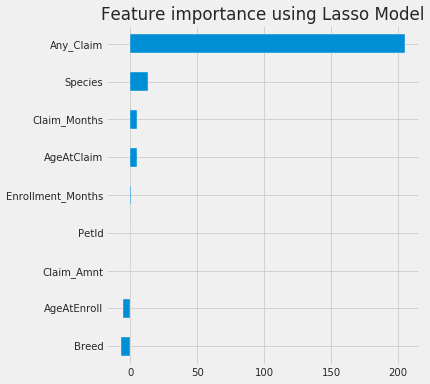

In [0]:
# Let's visualize it again
imp_coef = coef.sort_values()
import matplotlib
figure(num=None, figsize=(6, 7), dpi=60)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [0]:
#Now, let's  make a new dataframe for lasso prediction
df_lasso_pred= df_new
df_lasso_pred[['Species','Breed','Any_Claim', 'AgeAtEnroll']]= df[['Species','Breed','Any_Claim', 'AgeAtEnroll']]
df_lasso_pred.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 43022 entries, 37049 to 43021
Data columns (total 8 columns):
AgeAtClaim           43022 non-null float64
Claim_Months         43022 non-null int64
PetId                43022 non-null int64
Enrollment_Months    43022 non-null int64
Species              43022 non-null int64
Breed                43022 non-null int64
Any_Claim            43022 non-null int64
AgeAtEnroll          43022 non-null float64
dtypes: float64(2), int64(6)
memory usage: 4.2 MB


Label encode the df_total dataframe because it has object type columns that will be used in Lasso

In [0]:
from sklearn import preprocessing
import pandas as pd
le = preprocessing.LabelEncoder()

# df_total will be used as fitting the data.
# df_lasso_pred will be used for prediction.

df_total= df_before_dropping #We need to create original df_total again because with random forest, we chave changed df_total's original form

df_total[['Species', 'Breed', 'Any_Claim']] = df_total[['Species', 'Breed', 'Any_Claim']].apply(le.fit_transform)

In [0]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn import metrics

lasso_important = LassoCV( alphas = None, cv = 10, max_iter = 100000, normalize = True)

In [0]:
# Extract the most important features
# I will use df_total instead df dataset because I will use whole dataset, not the one prepared for train-test dataset
features= df_total.drop('ClaimAmount', axis = 1)
y= df_total['ClaimAmount']

# Now, let's make write important features for Lasso. 
# For important features I will choose only six features there were considered important in the "Feature Importance" plot.
important_indices= ['Species','Breed','Any_Claim', 'AgeAtEnroll', 'Claim_Months', 'AgeAtClaim']
fit_important = df_total.loc[:, important_indices] # This will be fitted
predict_important = df_lasso_pred.loc[:, important_indices] # df_lasso_pred will be predicted

#Now, we can fit and predict the model
lasso_important.fit(fit_important, y)
print("Best alpha using built-in LassoCV: %f" % lasso_important.alpha_)
print("Best score using built-in LassoCV: %f" %lasso_important.score(fit_important,y))
coef = pd.Series(lasso_important.coef_, index = important_indices )

Lasso_predictions = lasso_important.predict(predict_important)
Lasso_predictions.shape


Best alpha using built-in LassoCV: 0.000678
Best score using built-in LassoCV: 0.027065


(43022,)

In [0]:
coef

Species          23.102653
Breed            -7.270977
Any_Claim       403.238309
AgeAtEnroll       6.171662
Claim_Months      1.235803
AgeAtClaim       -4.830497
dtype: float64

### Now, we have the prediction values with lasso. But, it still needs to some cleaning for obtaining prediction values for each pet in the data. This model has duplicate PetID values. We need unique PetId values

We will repeat the steps that we have done at Random Forest

In [0]:
#Let's add the lasso predictions for July 2019 as a new column
df_total['Claim_Amount_July2019']= Lasso_predictions
df_total['Age_at_July_2019']= df_lasso_pred['AgeAtClaim'].round(0) # this can help fpr understanding the results
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43022 entries, 37049 to 43021
Data columns (total 15 columns):
PetId                    43022 non-null int64
ClaimAmount              43022 non-null float64
EnrollDate               43022 non-null datetime64[ns]
Species                  43022 non-null int64
Breed                    43022 non-null int64
AgeAtEnroll              43022 non-null float64
AgeAtClaim               43022 non-null float64
total_amount             43022 non-null float64
Claim_Months             43022 non-null float64
Enrollment_Months        43022 non-null int64
Any_Claim                43022 non-null int64
Claim_Amnt_Lately        43022 non-null float64
Claim_Amnt               43022 non-null float64
Claim_Amount_July2019    43022 non-null float64
Age_at_July_2019         43022 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(5)
memory usage: 6.5 MB


In [0]:
# I will evalutate the data per/pet anymore. Let's make some preparations for it.
# We will create a new column
df_total['Claim_Amount_July2019']= df_total.groupby('PetId').Claim_Amount_July2019.transform('mean')

In [0]:
# In order to make sanity check, original data can be useful. Therefore, I will merge this data to original data.
# Here are the sets of steps: 
df_merged= df_claim.merge(df_pet, on='PetId', how='right')
df_merged['total_claim_until_June']= df_claim.groupby('PetId').ClaimAmount.transform('sum')
df_merged.head()

,ClaimId,PetId,ClaimDate,ClaimAmount,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,total_claim_until_June
0,0.0,9273,2014-02-25,389.65,2013-01-01,2019-05-28,Dog,Mixed Breed,8 weeks to 12 months old,10628.36
1,1370.0,9273,2013-08-20,221.66,2013-01-01,2019-05-28,Dog,Mixed Breed,8 weeks to 12 months old,4957.69
2,1371.0,9273,2013-08-28,623.30,2013-01-01,2019-05-28,Dog,Mixed Breed,8 weeks to 12 months old,1971.04
3,1596.0,9273,2013-11-26,175.66,2013-01-01,2019-05-28,Dog,Mixed Breed,8 weeks to 12 months old,17208.98
4,1799.0,9273,2013-01-29,237.44,2013-01-01,2019-05-28,Dog,Mixed Breed,8 weeks to 12 months old,5871.33


Now, let's remove duplicate values for both df_merged data and df_total data. Thus, we can merge them properly.

In [0]:
df_merged= df_merged.drop_duplicates(['PetId']) # Drop duplicate PetId values
df_total_per_pet= df_total.drop_duplicates(['PetId']) # Drop duplicate PetId values

print(df_merged.shape)
print(df_total_per_pet.shape)

(10000, 10)
(10000, 15)


In [0]:
# Now, let's merge df_merged and df_total, and then name it df_prediction
df_prediction = df_merged.merge(df_total_per_pet[['PetId','Any_Claim','Age_at_July_2019','Claim_Amount_July2019']], on='PetId', how='right')
#Raname the AgeAtClaim Column as 'AgeAtJuly_2019'
df_prediction.shape

(10000, 13)

In [0]:
df_prediction.head()

,ClaimId,PetId,ClaimDate,ClaimAmount,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,total_claim_until_June,Any_Claim,Age_at_July_2019,Claim_Amount_July2019
0,0.0,9273,2014-02-25,389.65,2013-01-01,2019-05-28,Dog,Mixed Breed,8 weeks to 12 months old,10628.36,1,7.0,429.521572
1,1.0,1988,2014-03-10,455.40,2013-11-24,NaN,Dog,Golden Retriever,8 weeks to 12 months old,4488.30,1,6.0,448.416747
2,2.0,2452,2014-04-02,1953.79,2013-03-11,2017-08-08,Dog,Mixed Breed,8 weeks to 12 months old,14240.36,1,7.0,430.636750
3,3.0,3658,2014-04-05,243.74,2009-11-22,2019-01-10,Dog,Mixed Breed,8 weeks to 12 months old,5310.95,1,10.0,414.559246
4,5.0,9147,2014-03-18,206.42,2011-12-16,2017-05-16,Dog,Mixed Breed,6 years old,11139.80,1,14.0,431.528377


In [0]:
#df_prediction= df_prediction.drop(['Claim_Amount_July2019_x','Claim_Amount_July2019_y', axis=1])

In [0]:
df_prediction.PetId.sort_values()

4027       0
4028       1
2010       2
4029       3
3845       4
        ... 
1142    9995
3952    9996
9998    9997
1223    9998
9999    9999
Name: PetId, Length: 10000, dtype: int64

**Now, let's make zero for all Claim Amout of July 2019 for canceled plans .**

In [0]:
df_prediction['Claim_Amount_July2019'] = np.where((df_prediction.CancelDate.notnull()), 0, df_prediction.Claim_Amount_July2019).round(2)
df_prediction.sample(10)

,ClaimId,PetId,ClaimDate,ClaimAmount,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,total_claim_until_June,Any_Claim,Age_at_July_2019,Claim_Amount_July2019
5735,NaN,2831,NaN,NaN,2011-12-09,2012-10-03,Dog,Mixed Breed,2 years old,NaN,0,15.0,0.00
4425,NaN,680,NaN,NaN,2018-07-24,NaN,Cat,Mixed Breed,1 year old,NaN,0,5.0,17.65
9689,NaN,9476,NaN,NaN,2017-04-11,2018-03-09,Dog,French Bulldog,8 weeks to 12 months old,NaN,0,9.0,0.00
8787,NaN,7996,NaN,NaN,2013-06-11,2013-06-18,Dog,Chihuahua,9 years old,NaN,0,9.0,0.00
4679,NaN,1071,NaN,NaN,2012-08-29,2015-10-02,Cat,Mixed Breed,7 years old,NaN,0,5.0,0.00
698,1566.0,297,2013-11-23,4378.83,2013-11-15,2016-03-01,Dog,Mixed Breed,8 weeks to 12 months old,13225.3,1,6.0,0.00
6655,NaN,4370,NaN,NaN,2017-06-19,2018-09-13,Dog,French Bulldog,1 year old,NaN,0,9.0,0.00
5268,NaN,2079,NaN,NaN,2016-06-20,NaN,Dog,Mixed Breed,8 weeks to 12 months old,NaN,0,14.0,-4.72
7215,NaN,5283,NaN,NaN,2011-03-05,2014-01-20,Dog,Golden Retriever,8 weeks to 12 months old,NaN,0,9.0,0.00
6912,NaN,4780,NaN,NaN,2018-02-26,NaN,Cat,Mixed Breed,8 weeks to 12 months old,NaN,0,5.0,12.39


In [0]:
#Let's check the data again with notnull CancelDate values
df_prediction.loc[df_prediction.CancelDate.notnull()].sample(10)

,ClaimId,PetId,ClaimDate,ClaimAmount,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,total_claim_until_June,Any_Claim,Age_at_July_2019,Claim_Amount_July2019
4803,NaN,1274,NaN,NaN,2011-04-04,2012-10-05,Dog,Mixed Breed,8 weeks to 12 months old,NaN,0,17.0,0.0
9965,NaN,9937,NaN,NaN,2016-11-04,2016-11-07,Cat,Mixed Breed,5 years old,NaN,0,2.0,0.0
1400,4056.0,9966,2017-01-24,121.12,2016-12-17,2018-01-05,Dog,French Bulldog,8 weeks to 12 months old,720.26,1,3.0,0.0
4814,NaN,1293,NaN,NaN,2017-03-15,2017-10-24,Cat,Mixed Breed,2 years old,NaN,0,8.0,0.0
6379,NaN,3880,NaN,NaN,2011-07-24,2012-04-20,Cat,Mixed Breed,8 weeks to 12 months old,NaN,0,7.0,0.0
1499,4650.0,9206,2017-02-18,102.92,2015-12-22,2018-11-20,Dog,Mixed Breed,8 weeks to 12 months old,2010.77,1,4.0,0.0
8633,NaN,7731,NaN,NaN,2017-01-19,2019-01-22,Cat,Mixed Breed,7 years old,NaN,0,9.0,0.0
7447,NaN,5705,NaN,NaN,2012-01-10,2016-02-26,Cat,Mixed Breed,6 years old,NaN,0,4.0,0.0
3994,38491.0,7603,2011-03-11,304.75,2010-04-26,2015-01-02,Dog,Mixed Breed,1 year old,9751.52,1,10.0,0.0
6808,NaN,4612,NaN,NaN,2018-07-18,2018-10-04,Cat,Mixed Breed,8 weeks to 12 months old,NaN,0,7.0,0.0


Above table seems fine. All '**Claim_Amount_July2019**' values are zero if there is a **CancelDate**


---



# **Examining the Lasso prediction for checking it's robustness** 

##### Let's check whether there are any claim predictions for pets that are older than age of 20

In [0]:
df_prediction.loc[df_prediction.Age_at_July_2019 > 20]

,ClaimId,PetId,ClaimDate,ClaimAmount,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,total_claim_until_June,Any_Claim,Age_at_July_2019,Claim_Amount_July2019
75,151.0,4601,2017-01-10,132.96,2011-05-16,2018-04-20,Cat,Mixed Breed,13 years old,25113.89,1,21.0,0.0
604,1296.0,9067,2013-08-06,335.80,2010-08-03,2013-11-21,Cat,Mixed Breed,13 years old,25799.81,1,22.0,0.0
608,1308.0,4128,2013-09-22,1697.35,2011-11-15,2015-04-17,Cat,Mixed Breed,13 years old,1468.69,1,21.0,0.0
722,1644.0,7399,2013-12-05,2162.06,2010-02-17,2014-01-09,Cat,Mixed Breed,13 years old,9974.67,1,22.0,0.0
3490,25369.0,2606,2010-09-14,4601.74,2010-07-16,2010-09-23,Dog,Mixed Breed,13 years old,67687.66,1,22.0,0.0
3629,27802.0,6200,2014-10-26,1639.90,2011-12-16,2015-01-02,Cat,Mixed Breed,13 years old,7859.86,1,21.0,0.0
4019,40053.0,4813,2010-11-05,890.79,2010-09-30,2010-11-12,Cat,Mixed Breed,13 years old,7017.41,1,22.0,0.0
5612,NaN,2607,NaN,NaN,2018-08-16,2019-11-12,Cat,Mixed Breed,8 weeks to 12 months old,NaN,0,22.0,0.0


This seems fine. We don't have any claim prediction for the pets older than age of 21, which make sense.

---


Now, let's spend some time and keep checking the data. **Does it make sense? Are there any anomalies?** 


Sample() function gives us randomly selected columns. So, we can run this script again and again to see randomly selected columns


In [0]:
df_prediction.sample(20)

,ClaimId,PetId,ClaimDate,ClaimAmount,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,total_claim_until_June,Any_Claim,Age_at_July_2019,Claim_Amount_July2019
6212,NaN,3599,NaN,NaN,2019-10-17,NaN,Dog,Mixed Breed,8 weeks to 12 months old,NaN,0,8.0,20.84
9919,NaN,9862,NaN,NaN,2010-04-07,2011-09-19,Dog,Mixed Breed,4 years old,NaN,0,14.0,0.00
5307,NaN,2140,NaN,NaN,2017-02-04,NaN,Dog,Great Dane,8 weeks to 12 months old,NaN,0,9.0,25.95
178,312.0,7339,2017-01-20,123.79,2014-03-19,NaN,Dog,Mixed Breed,2 years old,90.62,1,7.0,437.07
9000,NaN,8331,NaN,NaN,2018-07-28,NaN,Cat,Mixed Breed,8 weeks to 12 months old,NaN,0,10.0,-11.56
4199,NaN,291,NaN,NaN,2018-03-25,NaN,Dog,Golden Retriever,8 weeks to 12 months old,NaN,0,5.0,50.51
3225,21128.0,1773,2017-05-07,149.33,2016-01-28,NaN,Dog,Mixed Breed,8 weeks to 12 months old,15616.79,1,4.0,444.54
4918,NaN,1475,NaN,NaN,2018-12-12,NaN,Cat,Mixed Breed,8 weeks to 12 months old,NaN,0,4.0,20.84
9611,NaN,9328,NaN,NaN,2014-06-01,2018-07-02,Dog,Mixed Breed,8 years old,NaN,0,14.0,0.00
7572,NaN,5920,NaN,NaN,2012-02-09,2017-05-09,Dog,Mixed Breed,8 weeks to 12 months old,NaN,0,4.0,0.00




---



**By examining above table, we can ca see some anomalies:** 

*   Some pets have claim prediction in July 2019 even though they don't have any in the past
*   There are some negative numbers
*   There are some big predicted claim amount numbers even though they don't have a claim history

**For adressing these issues:** 
* Negative values will be done zero
* If a pet has no claim, then predicted Claim Amount for July 2019 will be changed to zero



In [0]:
# Convert all negatives to zero
df_prediction['Claim_Amount_July2019'] = np.where((df_prediction.Claim_Amount_July2019 < 0), 0, df_prediction.Claim_Amount_July2019).round(2)
df_prediction.sample(5)

,ClaimId,PetId,ClaimDate,ClaimAmount,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,total_claim_until_June,Any_Claim,Age_at_July_2019,Claim_Amount_July2019
1478,4477.0,1825,2013-08-27,328.90,2012-08-07,NaN,Dog,Mixed Breed,1 year old,845.51,1,8.0,427.83
6544,NaN,4187,NaN,NaN,2016-05-03,NaN,Dog,Mixed Breed,2 years old,NaN,0,11.0,16.28
686,1534.0,7898,2013-11-12,485.73,2013-04-16,2014-08-21,Dog,Mixed Breed,8 weeks to 12 months old,23757.38,1,7.0,0.00
1183,3069.0,6478,2019-05-04,9.51,2013-07-17,NaN,Dog,Mixed Breed,5 years old,67687.66,1,11.0,437.86
6214,NaN,3603,NaN,NaN,2015-08-13,2017-03-10,Cat,Mixed Breed,10 years old,NaN,0,2.0,0.00


In [0]:
#Let's make a double check
df_prediction.loc[df_prediction['Claim_Amount_July2019'] < 0]

,ClaimId,PetId,ClaimDate,ClaimAmount,EnrollDate,CancelDate,Species,Breed,AgeAtEnroll,total_claim_until_June,Any_Claim,Age_at_July_2019,Claim_Amount_July2019


In [0]:
# If a pet has no claim, then predicted Claim Amount for July 2019 will be changed to zero
df_prediction['Claim_Amount_July2019'] = np.where((df_prediction.ClaimId.isnull()), 0, df_prediction.Claim_Amount_July2019).round(2)


In [0]:
df_prediction['ClaimDate'] = pd.to_datetime(df_prediction['ClaimDate'])
df_prediction['EnrollDate'] = pd.to_datetime(df_prediction['EnrollDate'])
df_prediction['CancelDate'] = pd.to_datetime(df_prediction['CancelDate'])

In [0]:
df_prediction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 13 columns):
ClaimId                   4027 non-null float64
PetId                     10000 non-null int64
ClaimDate                 4027 non-null datetime64[ns]
ClaimAmount               4027 non-null float64
EnrollDate                10000 non-null datetime64[ns]
CancelDate                4879 non-null datetime64[ns]
Species                   10000 non-null object
Breed                     10000 non-null object
AgeAtEnroll               10000 non-null object
total_claim_until_June    4027 non-null float64
Any_Claim                 10000 non-null int64
Age_at_July_2019          10000 non-null float64
Claim_Amount_July2019     10000 non-null float64
dtypes: datetime64[ns](3), float64(5), int64(2), object(3)
memory usage: 1.1+ MB


# **Do these predictions make sense?** 

Let's make a simple sanity check. We can compare total claim amount for July 2019 and previous months.

In [0]:
# Total claim amounts for last 10 months

a= df_before_dropping.groupby('Claim_Months', sort= True).ClaimAmount.agg(['sum','count'])
a.sort_values('Claim_Months', ascending=False).head(10)


,sum,count
Claim_Months,,
114.0,342772.06,789
113.0,375946.30,922
112.0,316541.57,824
111.0,306337.40,847
110.0,249323.96,724
109.0,343733.99,819
108.0,289373.16,744
107.0,311718.98,761
106.0,274719.77,822


In [0]:
# Total claim amount for July 2019
df_prediction.Claim_Amount_July2019.sum()

1088420.19

# **Evaluation** 



Similar to what we did at Random Forest, by looking at last 10 months, we can expect that total claim amount for July 2019 must be between **300-400k**. However, **~1088k** is not even close to this interval. Therefore, our lasso model is not making robust predictions. However, it's still not as bad as random forest. Remember than random forest predicted total claim amount in July 2019 is around **2500k**. Therfore, we can say that Lasso worked better than Random Forest.

Compared to Random Forest, Lasso is not using **PetId** as a strong predictor. Instead, **Any_Claim** is the most dominant predictor for the Lasso model. This probably affected Lasso's performance positively compared to Random Forest. Rememer that **Any_Claim has two values: 'Yes' and 'No'**. On the other hand, Any_Claim put a strong emphaises on this predictor. This caused that if a Pet has a claim in the Pet, the model expects to have a claim in the future as well.


I am well aware of that the model I developed is not usable for prediction because of it's poor performance. However, I have worked on this data alone, and with limited time. I didn't have enough time to extract more creative features, and didn't have team members that can share ideas and show me the points that I am missing. I believe that with a team and more time, I can develop way better and promising predictive models. 

---




# **Suggestion for Future Studies**


**1) Model for individual pets**

The models that I used didn't focused on enough on individual pets. 

##### **10 Highest number of claims for a pet:**  
    306
    242
    196
    171
    170
    170
    147
    140
    130
    123

Number of unique PetId in claim data:  **4027**

Here, we can see that there are certain pets that made claim many times. On the other hand, out of 10,000 pets, only 4027 of them made at least one claim. Therefore, developing a model that focuses more on individual pet may improve the prediction performance. We need to keep in mind that our best predictive model, Random Forest, also listed PetId as a strong predictor for claim amount.



**2) More insight on the difference between enrollment date, cancel date and claim amount**

Again, Random Forest model listed enrollment date as the fourth strongest predictor for claim amount. This hints that dates are important features for the prediction for this data. My models may be improved by adding more features such as **the difference between enrollment date, claim date and cancel date**.



**3) Filling the missing ClaimDate values**

Modelling such a data with strong predictors is a challenging task. There must a better way to handle with this missing data that how I did in this assignment. Informed decisions may inspire better ideas for handling with missing ClaimDate feature. 


**4) Mahalanobis distance for Outlier Detection**


For outlier detection, in this study, I used a method that I inspired from the studentized residual calculating method. However, my method can't detect outliers in high dimension. **Mahalanobis distance** can be effective at this situation. With a multi-dimensional generalization of the idea of measuring how many standard deviations is away from the mean, outliers can be detected better. This leads that the data cleaning can be done better, and model performance might be improved. 

**5) Notes on scaling the data**

For decreasing the affect of the outliers, I used **RobustScaler** at the ***pre-processing the data*** phase. However, in my further analysis, I run the model with **StandardScaler** and **without any scaler**. StandardScaler didn't change performance of the any model. With StandardScaler, prediction models gave exactly the same results with RobustScaler. In the case of no scaling the data, the performance of the XGB improved slightly, but still couldn't outperform the Random Forest model.

**6) Using time series for prediction**

Using time series for analysis is worthwhile to see. Time series is important because predicting claim amount at July 2019  involves a time component. This time component that makes the prediction more difficult to handle.

**7) Group Lasso could be used**

We have categorical features in the dataset. Therefore, we might have use **Group Lasso** to accomodate categorical variables. However, our ultimate target is prediction, not inference. Therefore, for the simplicity, we have used a regular lasso where the categorical features were treated as numerical data with the help of label encoder.